<span style="color:darkblue; font-size:36px;font-weight:bold;"><i>This code runs inverse-closure calculations and produces most of the figures in the manuscript.</i></span>


<span style="color:darkblue; font-size:18px;font-weight:bold;"><i> Define important functions</i></span>


def execute_test_run(Extra, NSD, pars = None):
    """
    Executes a test run to calculate the cloud condensation nuclei (CCN) concentration
    and kappa values based on input parameters.

    Parameters:
    - pars: list or array
        Parameter values for the calculation, which include mass fractions.
    - Extra: dict
        Additional parameters such as temperature, surface tension, and particle properties.
    - NSD: numpy array
        Number size distribution for particles.

    Returns:
    - S: numpy array
        Calculated cloud condensation nuclei (CCN) concentrations.
    - k: float
        Calculated kappa value for the particles.
    - kappa_inorg: float
        Kappa value for inorganic components.
    """
    # Initialize variables to store results
    S = None
    k = None
    
    # Extract temperature and surface tension from Extra
    T = Extra['temp']        # Temperature in Kelvin
    SIGMA = Extra['sigma']   # Surface tension in N/m
    
    # return the values based on the Kappa_switch
    if Extra['Kappa_switch'] == 0:
        # Use fixed kappa value (e.g., 0.18) from Sihto et al. 2011
        ccn, dact_arr = kappa_kohler_module(Extra, NSD, pars, T, SIGMA)
        return ccn, dact_arr
        
    elif Extra['Kappa_switch'] == 1:
        # Calculate kappa from chemical composition
        # Call the kappa_kohler_module to calculate CCN, kappa, and inorganic kappa
        ccn, dact, kappa, kappa_inorg = kappa_kohler_module(Extra, NSD, pars, T, SIGMA)
        return ccn, dact, kappa, kappa_inorg

    elif Extra['Kappa_switch'] == 2:
        # # calculate kappa from chemical composition but organic kappa is 0
        # Call the kappa_kohler_module to calculate CCN, kappa, and inorganic kappa
        ccn, dact, kappa, kappa_inorg = kappa_kohler_module(Extra, NSD, pars, T, SIGMA)
        return ccn, dact, kappa, kappa_inorg

    else:
        raise ValueError("Invalid Kappa_switch value. Use 0 for fixed kappa or 1 for calculated kappa.")


def kappa_kohler_module(Extra, NSD, pars_temp, T, SIGMA):
    """
    Calculates cloud condensation nuclei (CCN) concentration and kappa values
    using the kappa-Köhler theory.

    Parameters:
    - Extra: dict
        Additional parameters such as densities and critical supersaturation.
    - NSD: numpy array
        Number size distribution for particles.
    - pars_temp: list or array
        Parameter values for the calculation, which include mass fractions.
    - T: float
        Temperature in Kelvin.
    - SIGMA: float
 #       Surface tension in N/m.

    Returns:
    - ccn: numpy array
        Calculated cloud condensation nuclei (CCN) concentrations.
    - kappa: float
        Calculated kappa value for the particles.
    - kappa_inorg: float
        Kappa value for inorganic components.
    """
    # Determine the kappa value based on the Kappa_switch
    if Extra['Kappa_switch'] == 0:
        # Use fixed kappa value (e.g., 0.18)
        kappa = 0.18
    elif Extra['Kappa_switch'] == 1:
        # Calculate kappa from chemical composition
        kappa = cal_kappa(Extra, pars_temp)[0]

    elif Extra['Kappa_switch'] == 2:
        # calculate kappa from chemical composition but organic kappa is 0
        kappa = cal_kappa(Extra, pars_temp)[0]
    else:
        raise ValueError("Invalid Kappa_switch value. Use 0 for fixed kappa or 1 for calculated kappa.")

    scrit_kappa = []  # List to store critical supersaturation values for kappa

    # Extract additional parameters from Extra
    dp_dry = Extra['dp']            # Array of dry particle diameters in nm
    ss_amb = Extra['ss_amb']        # Ambient supersaturation levels in %
    d_lower_arr = Extra['d_lower_arr']  # Lower bound of diameter bins in nm
    d_upper_arr = Extra['d_upper_arr']  # Upper bound of diameter bins in nm
    wet_dia = Extra['wet_dia']      # Array of wet particle diameters in nm
    
    # Calculation of critical supersaturation from kappa-Köhler equation
    for dp in dp_dry:
        # Find index of first wet diameter greater than current dry diameter
        index = np.where(wet_dia > dp)[0][0]
        sliced_wet_dia = wet_dia[index:]  # Slice wet diameters to relevant range
        # Calculate supersaturation for each wet diameter
        SS_values = [kappa_kohler(w * 1e-9, dp * 1e-9, kappa, T, SIGMA) for w in sliced_wet_dia]
        # Store the maximum supersaturation value as the critical supersaturation
        scrit_kappa.append((max(SS_values) - 1) * 100)
    
    # Initialize CCN concentration array
    ccn = np.zeros(len(ss_amb))
    dact_arr = np.zeros(len(ss_amb))
    for i, ss in enumerate(ss_amb):
        try:
            act_bin = np.where(np.array(scrit_kappa) < ss)[0][0]

            ccn_x = np.sum(NSD[act_bin + 1:])  # Sum of number size distribution above activation bin
            
            # Calculate the slope for linear interpolation of activation diameter
            slope = (dp_dry[act_bin] - dp_dry[act_bin - 1]) / (scrit_kappa[act_bin] - scrit_kappa[act_bin - 1])
            dact = dp_dry[act_bin - 1] + (ss - scrit_kappa[act_bin - 1]) * slope  # Interpolated activation diameter
    
            # Calculate number of activated particles in the activation bin
            if dact > d_lower_arr[act_bin]:
                N_act_bin = NSD[act_bin] * (d_upper_arr[act_bin] - dact) / (d_upper_arr[act_bin] - d_lower_arr[act_bin])
            elif dact < d_lower_arr[act_bin]:
                multiplier = (d_upper_arr[act_bin - 1] - dact) / (d_upper_arr[act_bin - 1] - d_lower_arr[act_bin - 1])
                N_act_bin = NSD[act_bin] + NSD[act_bin - 1] * multiplier
    
            # Calculate total CCN concentration
            ccn[i] = ccn_x.item() + N_act_bin.item()
            dact_arr[i] = dact.item()
        except:
            ccn[i] = 0
            dact_arr[i] = dp_dry[-1]
    
    # return the values based on the Kappa_switch
    if Extra['Kappa_switch'] == 0:
        # Used fixed kappa value (e.g., 0.18)
        return ccn, dact_arr
        
    elif Extra['Kappa_switch'] == 1:
        # Calculated kappa from chemical composition
        return ccn, dact_arr, kappa, cal_kappa(Extra, pars_temp)[1]

    elif Extra['Kappa_switch'] == 2:
        # Calculated kappa from chemical composition and organic kappa = 0 
        return ccn, dact_arr, kappa, cal_kappa(Extra, pars_temp)[1]
        
    else:
        raise ValueError("Invalid Kappa_switch value. Use 0 for fixed kappa or 1 for calculated kappa.")

def cal_kappa(Extra, mass):
    """
    Calculate the kappa hygroscopicity parameter for the particle based on its composition.

    Parameters:
    - Extra: dict
        Additional parameters such as densities and hygroscopicity values.
    - mass: list or array
        Mass concentrations of different particle components.

    Returns:
    - kappa: list
        List containing the total kappa value for particles and the kappa for inorganics.
    """
    # Extract densities from Extra is in kg/m3
    rho_org = Extra['densities'][0]   # Density of organic material
    rho_sulp = Extra['densities'][1]   # Density of ammonium sulfate
    rho_nitr = Extra['densities'][2]  # Density of ammonium nitrate
    rho_bc = Extra['densities'][3]   # Density of black carbon
    
    # Hygroscopicity values for different components
    k_Org = Extra['kappa_org']  # Kappa for organics
    k_N = Extra['kappa_NH4NO3']             # Kappa for ammonium nitrate
    k_s = Extra['kappa_NH4SO4']  
    k_bc = Extra['eBC']  # Kappa for black carbon (assumed non-hygroscopic)

    # Calculate net hygroscopicity parameter for inorganics
    tot_vol_inorg = Extra['true_inputs'][2]/rho_sulp + Extra['true_inputs'][3]/rho_nitr
    k_s = k_s * (Extra['true_inputs'][2]/rho_sulp) / tot_vol_inorg + k_N * (Extra['true_inputs'][3]/rho_nitr) / tot_vol_inorg

    #calculate net inorganic density
    rho_inorg = Extra['rho_inorg']
    
    # Calculate total particle volume
    tot_vol = (
        mass[0]/rho_org +  # Volume of organic material
        mass[2]/rho_inorg + # Volume of inorganics
        mass[3]/rho_nitr + # Volume of ammonium nitrate
        mass[4]/rho_bc     # Volume of black carbon
    )

    # Calculate contributions to kappa from each component
    k1 = k_Org * (mass[0]/rho_org) / tot_vol  # Contribution from organics
    k2 = k_s * (mass[2]/rho_inorg) / tot_vol   # Contribution from inorganics
    k3 = k_N * (mass[3]/rho_nitr) / tot_vol   # Contribution from ammonium nitrate (is zero currently)
    k4 = k_bc * (mass[4]/rho_bc) / tot_vol

    # Total kappa value
    kappa = k1 + k2 + k3 + k4

    return [kappa, k_s]

def kappa_kohler(Dwet, Ddry, kappa, T, sigma):
    """
    Calculate the equilibrium supersaturation (s_eq) using the kappa-Köhler equation.

    Parameters:
    - Dwet: float
        Wet particle diameter in meters.
    - Ddry: float
        Dry particle diameter in meters.
    - kappa: float
        Hygroscopicity parameter.
    - T: float
        Temperature in Kelvin.
    - sigma: float
        Surface tension in N/m.

    Returns:
    - s_eq: float
        Equilibrium supersaturation.
    """
    Mw = 18.016 * 1e-3  # Molar mass of water in kg/mol
    R = 8.314           # Universal gas constant in J/(mol*K)
    rhow = 1000         # Density of water in kg/m^3

    # Calculate the numerator and denominator of the kappa-Köhler equation
    fact_num = Dwet**3 - Ddry**3
    fact_denum = Dwet**3 - Ddry**3 * (1 - kappa)

    # Calculate the exponential term of the kappa-Köhler equation
    exp_term = np.exp((4 * sigma * Mw) / (R * T * rhow * Dwet))

    # Calculate the equilibrium supersaturation
    s_eq = (fact_num / fact_denum) * exp_term

    return s_eq

def cal_mass(Dp, mass_frac, Extra, nsd1, nsd2):
    """
    Calculate the total mass of particles in two modes based on their size distribution,
    densities, and composition fractions.

    Parameters:
    - Dp: numpy array
        Dry particle diameters in nanometers.
    - mass_frac: list
        Mass fractions of the components in the particles: [Org, Other, NH4SO4, NH4NO3, BC].
    - Extra: dict
        Additional parameters such as densities of components.
    - nsd1: numpy array
        Number size distribution for mode 1 in cm^(-3) nm^(-1).
    - nsd2: numpy array
        Number size distribution for mode 2 in cm^(-3) nm^(-1).

    Returns:
    - mass_info: dict
        Dictionary containing the total mass and individual component masses in micrograms per cubic meter.
    """

    # Extract component densities from the 'Extra' dictionary
    rho_org = Extra['densities'][0]   # Density of organic material in kg/m^3
    rho_sulp = Extra['densities'][1]  # Density of ammonium sulfate (NH4SO4) in kg/m^3
    rho_nitr = Extra['densities'][2]  # Density of ammonium nitrate (NH4NO3) in kg/m^3
    rho_bc = Extra['densities'][3]    # Density of black carbon (BC) in kg/m^3

    # Calculate the net density of the internally mixed particles
    rho_tot = (
        mass_frac[0] * rho_org +  # Contribution from organic materials
        mass_frac[2] * rho_sulp + # Contribution from ammonium sulfate
        mass_frac[3] * rho_nitr + # Contribution from ammonium nitrate
        mass_frac[4] * rho_bc     # Contribution from black carbon
    )

    # Calculate the total mass in kg for mode 1
    mass_mode1 = rho_tot * (nsd1 * 1e6) * (4 / 3) * np.pi * (Dp * 1e-9 / 2) ** 3
    # The formula above converts number concentration to volume, and multiplies by density

    # Calculate the total mass in kg for mode 2
    mass_mode2 = rho_tot * (nsd2 * 1e6) * (4 / 3) * np.pi * (Dp * 1e-9 / 2) ** 3
    # Similar conversion as mode 1, but using mode 2 number size distribution

    # Calculate the total mass for both modes
    total_mass = sum(mass_mode2) + sum(mass_mode1)

    # Convert total and component masses to micrograms per cubic meter
    mass_info = {
        'total_mass': total_mass * 1e9,
        'tot_mass_mode1': sum(mass_mode1) * 1e9,
        'tot_mass_mode2': sum(mass_mode2) * 1e9,
        'M_org1': mass_frac[0] * sum(mass_mode1) * 1e9,
        'M_AS1': mass_frac[2] * sum(mass_mode1) * 1e9,
        'M_AN1': mass_frac[3] * sum(mass_mode1) * 1e9,
        'M_BC1': mass_frac[4] * sum(mass_mode1) * 1e9,
        'M_org2': mass_frac[0] * sum(mass_mode2) * 1e9,
   <span style="color:darkblue; font-size:18px;"><i> Define important functions</i></span>
     'M_AS2': mass_frac[2] * sum(mass_mode2) * 1e9,
        'M_AN2': mass_frac[3] * sum(mass_mode2) * 1e9,
        'M_BC2': mass_frac[4] * sum(mass_mode2) * 1e9,
        'tot_org': mass_frac[0] * total_mass * 1e9,
        'tot_AS': mass_frac[2] * total_mass * 1e9,
        'tot_AN': mass_frac[3] * total_mass * 1e9,
        'tot_BC': mass_frac[4] * total_mass * 1e9
    }

    return mass_info


<span style="color:darkblue; font-size:20px;font-weight:bold;"><i> I use Nelder-Mead and initialize with initial organic mass in mode 1 or Aitken mode which is equivalent to using bulk chemical composition. </i></span> 

In [7]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import os 

# Note: AS and AN are treated as inorganics here, so be cautious within the objective function 
# where the mass fractions are defined accordingly.
# For Aitken mode: mass_frac_aitken = [f_org1, tot_frac1_vec, f_AS1, 0, f_BC1]

# Define Extra dictionary to store additional parameters
Extra = {}

# Initialize the Kappa_switch to 0 by default
# Kappa_switch = 0 indicates that a fixed value of kappa (e.g., 0.18) will be used in calculations
#Extra['Kappa_switch'] = 0

# Change Kappa_switch to 1 when chemical composition is used to calculate kappa
# Kappa_switch = 1 signals that kappa should be calculated dynamically based on the chemical composition
Extra['Kappa_switch'] = 1

# Define observed data directory, go to input_data/ directory and gather all input data there running the code 'input_data.ipynb'
obs_dir = 'input_data/'

# Load Dp.txt file (dry particle diameter data)
with open(os.path.join(obs_dir, 'Dp.txt'), 'r') as file_dp_open:
    dp_dry = np.array([float(val) for val in file_dp_open.read().split()])

# Store dp_dry in nanometers in Extra dictionary
Extra['dp'] = dp_dry  # in nanometer
# Define sigma values
sigma_ls = [72.8, 30, 35, 40, 45, 50, 60, 70] #in mN/m

# Densities of various components (kg/m^3)
Extra['densities'] = [1.50*1e3, 1.77*1e3, 1.71*1e3, 1.77*1e3]
rho_org = Extra['densities'][0]
rho_sulp = Extra['densities'][1]
rho_nitr = Extra['densities'][2]
rho_bc = Extra['densities']

Extra['kappa_org'] = 0.12  # Kappa value (hygroscopicity parameter) for organic compounds
Extra['kappa_NH4SO4'] = 0.61  # Kappa value (hygroscopicity parameter) for ammonium sulfate (NH4)2SO4
Extra['kappa_NH4NO3'] = 0.67  # Kappa value (hygroscopicity parameter) for ammonium nitrate NH4NO3
Extra['eBC'] = 0  # Kappa value (hygroscopicity parameter) for black carbon

Extra['sigma'] = sigma_ls[0] * 1e-3  # Surface tension value in N/m, converted from the given sigma list in milli-Newtons/meter
Extra['ss_amb'] = [0.1, 0.2, 0.3, 0.5, 1.0]  # Ambient supersaturation values as in the CCN counter (in percentage), CCN calculations
Extra['wet_dia'] = np.logspace(0, 4.35, 200)  # Wet diameter of particles in nanometers, logarithmically spaced between 1 nm and 10^4.35 nm over 200 points
Extra['temp'] = 298.48  # Median temperature in Kelvin, the hut median temperature over the entire timeseries (approximately 25.33°C)

# Calculate the initial upper and lower boundaries for the first dry particle diameter (dp_dry)
d_upper0 = dp_dry[0] + (dp_dry[1] - dp_dry[0]) / 2  # Upper boundary for the first bin
d_lower0 = dp_dry[0] - (dp_dry[1] - dp_dry[0]) / 2  # Lower boundary for the first bin

# Initialize arrays to store the lower and upper boundaries of all dry particle diameters
# Using np.full_like to create arrays of the same shape as dp_dry, filled with the initial lower/upper values
d_lower_arr_vec = np.full_like(dp_dry, d_lower0)  # Array for lower boundaries, starting with d_lower0
d_upper_arr_vec = np.full_like(dp_dry, d_upper0)  # Array for upper boundaries, starting with d_upper0

# Populate the arrays with the upper and lower diameter boundaries for each particle size
for i in range(1, len(dp_dry)):
    d_lower_arr_vec[i] = d_upper_arr_vec[i - 1]  # Lower boundary for the current bin equals the upper boundary of the previous bin
    d_upper_arr_vec[i] = dp_dry[i] + dp_dry[i] - d_lower_arr_vec[i]  # Upper boundary calculated based on particle diameter and lower boundary

# Store the lower and upper boundary arrays in the 'Extra' dictionary for later use
Extra['d_lower_arr'] = d_lower_arr_vec  # Lower boundary array
Extra['d_upper_arr'] = d_upper_arr_vec  # Upper boundary array

# Load observed data from CSV files
# nsd_abs1 and nsd_abs2: Number Size Distribution (NSD) data for mode 1 and mode 2
# comp_obs: Composition observation data
# ccn_obs: Cloud Condensation Nuclei (CCN) observation data
nsd_abs1 = pd.read_csv(os.path.join(obs_dir, 'NSD_mode1.csv'))  # Load NSD data for mode 1
nsd_abs2 = pd.read_csv(os.path.join(obs_dir, 'NSD_mode2.csv'))  # Load NSD data for mode 2
comp_obs = pd.read_csv(os.path.join(obs_dir, 'comp.csv'))  # Load observed composition data, mass fractions/concentrations
ccn_obs = pd.read_csv(os.path.join(obs_dir, 'CCN.csv'))  # Load observed CCN data

# Print the lengths of each dataframe to check the number of rows loaded from each file
print("Length of nsd_abs1:", len(nsd_abs1))  # Output the number of rows in nsd_abs1
print("Length of nsd_abs2:", len(nsd_abs2))  # Output the number of rows in nsd_abs2
print("Length of comp_obs:", len(comp_obs))  # Output the number of rows in comp_obs
print("Length of ccn_obs:", len(ccn_obs))    # Output the number of rows in ccn_obs

# Check if the lengths of all the datasets are equal
# The lengths of nsd_abs2, comp_obs, and ccn_obs must match the length of nsd_abs1
if not all(len(df) == len(nsd_abs1) for df in [nsd_abs2, comp_obs, ccn_obs]):
    # Raise an error if the lengths of the datasets are not equal
    raise ValueError("Lengths of the datasets are not equal.")

# List to store results for each iteration
results = []
predicted_CCN_ACSM_ls = []
predicted_dact_ACSM_ls = []
kappa_ACSM_ls = []
explored_nrmse_morg1 = []
# Main optimization loop over all data points
for i in range(len(nsd_abs1)):
#for i in range(10):

    # Get the particle size distribution vectors for Aitken and Accumulation modes
    NSD1_vec = np.array(nsd_abs1.iloc[i, 1:].values.tolist())
    NSD2_vec = np.array(nsd_abs2.iloc[i, 1:].values.tolist())

    #print(NSD1_vec)
    
    # Observed CCN response data
    response = ccn_obs.iloc[i, 1:].values
    
    # Inputs from ACSM and eBC observation data
    Extra['true_inputs'] = [
        comp_obs.loc[i, 'Org'],
        comp_obs.loc[i, 'total_mass'], 
        comp_obs.loc[i, 'NH4SO4'], 
        comp_obs.loc[i, 'NH4NO3'], 
        comp_obs.loc[i, 'eBC880']
    ]
    
    # Calculate masses of ammonium sulfate and nitrate
    mass_vec_NH4SO4 = comp_obs.loc[i, 'NH4SO4'] * comp_obs.loc[i, 'total_mass']
    mass_vec_NH4NO3 = comp_obs.loc[i, 'NH4NO3'] * comp_obs.loc[i, 'total_mass']
    
    # Mass fractions for ammonium sulfate and nitrate
    mass_frac_vec_NH4SO4 = mass_vec_NH4SO4 / (mass_vec_NH4SO4 + mass_vec_NH4NO3)
    mass_frac_vec_NH4NO3 = mass_vec_NH4NO3 / (mass_vec_NH4SO4 + mass_vec_NH4NO3)
    
    # Adjust density for inorganic components based on mass fractions
    Extra['rho_inorg'] = (mass_vec_NH4SO4 / (mass_vec_NH4SO4 + mass_vec_NH4NO3)) * rho_sulp + \
                         (mass_vec_NH4NO3 / (mass_vec_NH4SO4 + mass_vec_NH4NO3)) * rho_nitr
    
    # Call function to calculate masses of organics, inorganics, and black carbon
    info_mass = cal_mass(dp_dry, Extra['true_inputs'], Extra, NSD1_vec, NSD2_vec)
    
    # Initial values for mass fractions in Aitken and Accumulation modes
    initial_M_BC1 = info_mass['M_BC1']  # Black carbon in Aitken mode
    initial_M_BC2 = info_mass['M_BC2']  # Black carbon in Accumulation mode
    initial_M_org1 = info_mass['M_org1']  # Organics in Aitken mode
    initial_M_org2 = info_mass['M_org2']  # Organics in Accumulation mode
    initial_M_AS1 = info_mass['M_AS1']  # Ammonium sulfate in Aitken mode
    initial_M_AS2 = info_mass['M_AS2']  # Ammonium sulfate in Accumulation mode
    initial_M_AN1 = info_mass['M_AN1']  # Ammonium nitrate in Aitken mode
    initial_M_AN2 = info_mass['M_AN2']  # Ammonium nitrate in Accumulation mode
    tot_mass_org = info_mass['tot_org']
    tot_mass_AS = info_mass['tot_AS'] + info_mass['tot_AN']  # Total ammonium salts (sulfate + nitrate)
    initial_tot_acc_mass = info_mass['tot_mass_mode2']  # Total mass in Accumulation mode
    initial_tot_ait_mass = info_mass['tot_mass_mode1']  # Total mass in Aitken mode
    initial_tot_mass = initial_tot_ait_mass + initial_tot_acc_mass
    
    
    # Mass fractions for black carbon
    f_BC1 = initial_M_BC1 / initial_tot_ait_mass # aitken mode
    f_BC2 = initial_M_BC2 / initial_tot_acc_mass # accumulation mode

    # CCN prediction using bulk chemical composition (ACSM and Aethalometer observation)
    mass_frac_ACSM = [tot_mass_org/initial_tot_mass, 1, tot_mass_AS/initial_tot_mass, 0, f_BC1]
    predicted_CCN_ACSM, predicted_dact_ACSM, Kappa_ACSM, kappa_inorg = execute_test_run(Extra, NSD1_vec + NSD2_vec, pars = mass_frac_ACSM)

    rmse_ACSM = np.sqrt(np.mean((response - predicted_CCN_ACSM)**2))  # RMSE
    nrmse_ACSM = rmse_ACSM / np.mean(response)  # NRMSE calculation

    # save predicted CCN, activation diameter and kappa to different lists
    predicted_CCN_ACSM_ls.append([nsd_abs1.iloc[i, 0], predicted_CCN_ACSM])
    predicted_dact_ACSM_ls.append([nsd_abs1.iloc[i, 0], predicted_dact_ACSM])
    kappa_ACSM_ls.append([nsd_abs1.iloc[i, 0], Kappa_ACSM])
    
    # Define objective function to minimize NRMSE
    def objective_function(M_org1, return_all = False):
        global explored_nrmse_morg1
        # Calculate remaining mass in each mode
        M_AS1 = initial_tot_ait_mass - (M_org1 + initial_M_BC1) # inorganics mass in mode1
        M_org2 = tot_mass_org - M_org1 #organics mass in mode2
        M_AS2 = tot_mass_AS - M_AS1 #inorganics mass in mode2
        total_ait_mass = M_org1 + M_AS1 + initial_M_BC1
        total_acc_mass = M_org2 + M_AS2 + initial_M_BC2

        # Ensure masses are non-negative and within tolerance
        if (
            (0.99999 * initial_tot_ait_mass < total_ait_mass < 1.00001 * initial_tot_ait_mass) and
            (0.99999 * initial_tot_acc_mass < total_acc_mass < 1.00001 * initial_tot_acc_mass) and
            M_org2 >= 0 and M_AS2 >= 0 and M_AS1 >= 0 and M_org1 >= 0
        ):
            f_org1 = M_org1 / total_ait_mass
            f_AS1 = M_AS1 / total_ait_mass
            f_org2 = M_org2 / total_acc_mass
            f_AS2 = M_AS2 / total_acc_mass

            frac_org1 = M_org1 / (M_org1 + M_org2)
            frac_org2 = M_org2 / (M_org1 + M_org1)
            frac_AS1 = M_AS1 / (M_AS1 + M_AS2)
            frac_AS2 = M_AS2 / (M_AS1 + M_AS2)
            
            # calculate total mass fraction to check if the net is equal to 1
            tot_frac1_vec, tot_frac2_vec = f_org1 + f_AS1 + f_BC1, f_org2 + f_AS2 + f_BC2
            
            mass_frac_aitken = [f_org1, tot_frac1_vec, f_AS1, 0, f_BC1] # sequence is organics, total mass fraction/ inorganics, nitrate, eBC
            mass_frac_accumulation = [f_org2, tot_frac2_vec, f_AS2, 0, f_BC2]

            # Call the function to predict CCN
            predicted_CCN1, dact1, k1, kappa_inorg = execute_test_run(Extra, NSD1_vec, pars =  mass_frac_aitken) # Aitken CCN
            predicted_CCN2, dact2, k2, kappa_inorg = execute_test_run(Extra, NSD2_vec, pars = mass_frac_accumulation) # Accumulation CCN
            predicted_CCN = predicted_CCN1 + predicted_CCN2 # net CCN
            
            # Calculate NRMSE
            rmse = np.sqrt(np.mean((response - predicted_CCN)**2))  # RMSE
            nrmse = rmse / np.mean(response)  # NRMSE calculation

            # save the samples explored by the algorithm
            explored_nrmse_morg1.append([nsd_abs1.iloc[i, 0], M_org1, f_org1, frac_org1, frac_AS1, nrmse])
            # Return NRMSE or other values depending on the return_all flag
            if return_all:
                return nrmse.item(), predicted_CCN1, predicted_CCN2, Extra['rho_inorg'].item(), predicted_CCN, f_org1.item(), f_AS1.item(), f_BC1.item(), f_org2.item(), f_AS2.item(), f_BC2.item(), k1.item(), k2.item(), total_ait_mass.item(),total_acc_mass.item() 
            return nrmse  # Minimize this value during optimization
        else:
            return np.inf  # Return high error if constraints are violated

    # Minimize the objective function using the initial guess for M_org1 
    res = minimize(objective_function, x0 = [initial_M_org1], method = 'Nelder-Mead', options = {'fatol': 1e-4, 'xatol': 1e-5})
    
    # Check if optimization was successful
    if res.success:
        # Get the optimized value for M_org1
        optimized_M_org1 = res.x[0]
        
        # If you want additional outputs such as the NRMSE, you can call the objective function again
        # with the optimized value of M_org1
        nrmse, predicted_CCN1, predicted_CCN2, rho_inorg, predicted_CCN, f_org1, f_AS1, f_BC1, f_org2, f_AS2, f_BC2, k1, k2, mass_aitken, mass_accumulation  = objective_function(optimized_M_org1, return_all=True)

        # Calculate the sum of mass fractions for Aitken and Accumulation modes
        sum_mass_fractions_aitken = f_org1 + f_AS1 + f_BC1
        sum_mass_fractions_accumulation = f_org2 + f_AS2 + f_BC2
    
        # Store the results for this iteration
        results.append([nsd_abs1.iloc[i, 0], nrmse, predicted_CCN1, predicted_CCN2, rho_inorg, 
                        predicted_CCN, f_org1, f_AS1, f_BC1, f_org2, 
                        f_AS2, f_BC2, k1, k2, mass_aitken, mass_accumulation])

        # Print results for the current timestep
        print(f"Iteration {i + 1}:")
        print(f"NRMSE_opt: {nrmse}")
        print(f"NRMSE_ACSM: {nrmse_ACSM}")
        print(f"Predicted CCN: {predicted_CCN}")
        print(f"f_org1: {f_org1}, f_AS1: {f_AS1}, f_BC1: {f_BC1}")
        print(f"f_org2: {f_org2}, f_AS2: {f_AS2}, f_BC2: {f_BC2}")
        print(f"Sum of mass fractions (Aitken mode): {sum_mass_fractions_aitken}")
        print(f"Sum of mass fractions (Accumulation mode): {sum_mass_fractions_accumulation}")
        print(f"k1: {k1}, k2: {k2}")
        print("-" * 40)

# Convert to DataFrame
columns_explored = ['datetime', 'f_org1', 'frac_org1', 'frac_AS1', 'NRMSE']
explored_df = pd.DataFrame(explored_nrmse_morg1, columns=columns_explored)

# Save the explored samples to CSV file
explored_df.to_csv('explored_f_org1_NRMSE.csv', index=False)

# Convert results to a pandas DataFrame
columns = ['datetime', 'NRMSE', 'predicted_CCN1', 'predicted_CCN2', 'inorg_density', 'Predicted_CCN', 'f_org1', 'f_AS1', 'f_BC1', 'f_org2', 'f_AS2', 'f_BC2', 'k1', 'k2','mass_aitken', 'mass_accumulation']
results_df = pd.DataFrame(results, columns = columns)
#Save otimized results to a CSV file
results_df.to_csv('result_nedler_mead_org0p12.csv')


# save predicted CCN – used bulk chemical composition
columns_bulk_ccn = ['datetime', 'Predicted_CCN_ACSM']
bulk_CCN_df = pd.DataFrame(predicted_CCN_ACSM_ls, columns=columns_bulk_ccn)
bulk_CCN_df.to_csv('CCN_ACSM_eBC.csv')

# save kappa values - used bulk chemical composition
columns_bulk_kappa = ['datetime', 'kappa']
bulk_kappa_df = pd.DataFrame(kappa_ACSM_ls, columns=columns_bulk_kappa)
bulk_kappa_df.to_csv('kappa_ACSM_eBC_org0p12.csv')

# save activation diameter – used bulk chemical composition
columns_bulk_dact = ['datetime', 'dact']
bulk_dact_df = pd.DataFrame(predicted_dact_ACSM_ls, columns=columns_bulk_dact)
bulk_dact_df.to_csv('Dact_ACSM_eBC_org0p12.csv')

Length of nsd_abs1: 6580
Length of nsd_abs2: 6580
Length of comp_obs: 6580
Length of ccn_obs: 6580
Iteration 1:
NRMSE_opt: 0.20124412978364883
NRMSE_ACSM: 0.25574750989158257
Predicted CCN: [ 82.63042095 141.49618239 174.54355345 218.58103063 260.36721824]
f_org1: 0.00022425378149131586, f_AS1: 0.9760391393834319, f_BC1: 0.023736606835076796
f_org2: 0.5929662512520525, f_AS2: 0.38329714191287073, f_BC2: 0.023736606835076803
Sum of mass fractions (Aitken mode): 1.0
Sum of mass fractions (Accumulation mode): 1.0
k1: 0.5973376617196781, k2: 0.28793539109889865
----------------------------------------
Iteration 2:
NRMSE_opt: 0.07936811352558391
NRMSE_ACSM: 0.1214241340842296
Predicted CCN: [110.43237989 185.84076701 223.53819704 268.92372245 297.20032097]
f_org1: 0.0002411893571053212, f_AS1: 0.9699592512716754, f_BC1: 0.0297995593712193
f_org2: 0.6363707040780704, f_AS2: 0.33382973655071035, f_BC2: 0.029799559371219298
Sum of mass fractions (Aitken mode): 1.0
Sum of mass fractions (Accumu

/var/folders/8f/8p3mj3sd6cx4f_2hmmh5q86c0000gn/T/ipykernel_49264/738690632.py:185: RuntimeWarning: divide by zero encountered in divide
  frac_org2 = M_org2 / (M_org1 + M_org1)
/var/folders/8f/8p3mj3sd6cx4f_2hmmh5q86c0000gn/T/ipykernel_49264/738690632.py:185: RuntimeWarning: divide by zero encountered in scalar divide
  frac_org2 = M_org2 / (M_org1 + M_org1)


Iteration 26:
NRMSE_opt: 0.08374007032756478
NRMSE_ACSM: 0.14493099391668132
Predicted CCN: [203.48038649 430.98183171 593.51842603 753.71889976 841.87615316]
f_org1: 0.0, f_AS1: 0.9451779244542853, f_BC1: 0.05482207554571471
f_org2: 0.7362300625263807, f_AS2: 0.20894786192790465, f_BC2: 0.0548220755457147
Sum of mass fractions (Aitken mode): 1.0
Sum of mass fractions (Accumulation mode): 1.0
k1: 0.5808992483981824, k2: 0.20561371643477566
----------------------------------------
Iteration 27:
NRMSE_opt: 0.11108534838416302
NRMSE_ACSM: 0.17106996122693172
Predicted CCN: [237.07744455 446.20312799 597.05092326 751.25374408 842.15930541]
f_org1: 4.741030551502332e-16, f_AS1: 0.9539491441983922, f_BC1: 0.0460508558016074
f_org2: 0.6302826922828724, f_AS2: 0.3236664519155204, f_BC2: 0.0460508558016074
Sum of mass fractions (Aitken mode): 1.0
Sum of mass fractions (Accumulation mode): 1.0000000000000002
k1: 0.584148951041404, k2: 0.25827635773062874
----------------------------------------


/var/folders/8f/8p3mj3sd6cx4f_2hmmh5q86c0000gn/T/ipykernel_49264/738690632.py:156: RuntimeWarning: divide by zero encountered in scalar divide
  nrmse_ACSM = rmse_ACSM / np.mean(response)  # NRMSE calculation
/var/folders/8f/8p3mj3sd6cx4f_2hmmh5q86c0000gn/T/ipykernel_49264/738690632.py:202: RuntimeWarning: divide by zero encountered in scalar divide
  nrmse = rmse / np.mean(response)  # NRMSE calculation
/opt/homebrew/Caskroom/miniforge/base/envs/Rahul/lib/python3.11/site-packages/scipy/optimize/_optimize.py:851: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Iteration 441:
NRMSE_opt: 13.467520747416089
NRMSE_ACSM: 14.561592644668192
Predicted CCN: [269.38323488 327.66685052 342.62903343 360.34950237 409.42416106]
f_org1: 0.9428210925728927, f_AS1: 1.2829611402238583e-07, f_BC1: 0.0571787791309933
f_org2: 0.3029352177881537, f_AS2: 0.6398860030808531, f_BC2: 0.0571787791309933
Sum of mass fractions (Aitken mode): 1.0
Sum of mass fractions (Accumulation mode): 1.0
k1: 0.11413409892448086, k2: 0.41250716522812997
----------------------------------------
Iteration 442:
NRMSE_opt: 0.4017774299011853
NRMSE_ACSM: 0.5194900068540484
Predicted CCN: [214.36901729 303.77090998 330.97884826 362.02344493 433.57374551]
f_org1: 0.8976442056791673, f_AS1: 1.9346680572741152e-05, f_BC1: 0.10233644764025988
f_org2: 0.39024442148188987, f_AS2: 0.5074191308778502, f_BC2: 0.1023364476402599
Sum of mass fractions (Aitken mode): 0.9999999999999999
Sum of mass fractions (Accumulation mode): 1.0
k1: 0.1094361186782797, k2: 0.34399959640504907
---------------------

<span style="color:darkblue; font-size:18px;font-weight:bold;"><i> check output data</i></span>
 

In [82]:
import pandas as pd

# Read the CSV file
results_df = pd.read_csv('result_nedler_mead_org0p12.csv')
results_df['datetime'] = pd.to_datetime(results_df['datetime'])
results_df.set_index('datetime', inplace=True)

# Add a 'season' column
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'

results_df['season'] = results_df.index.month.map(get_season)

# Group by season and calculate the median for k1 and k2
seasonal_median = results_df.groupby('season')[['k1', 'k2']].median()

# Print the results in the sequence spring, summer, autumn, winter
seasonal_median = seasonal_median.reindex(['spring', 'summer', 'autumn', 'winter'])
print(seasonal_median)


              k1        k2
season                    
spring  0.115317  0.269491
summer  0.116563  0.215406
autumn  0.113335  0.245476
winter  0.110285  0.289497


<span style="color:darkblue; font-size:18px;font-weight:bold;"><i> print mean of the optimized mass fractions in Aitken mode and accumulation mode </i></span>

In [83]:
results_df[['f_org1', 'f_AS1', 'f_org2', 'f_AS2']].mean()
results_df[['f_org1', 'f_AS1', 'f_org2', 'f_AS2']].mean()

f_org1    0.724778
f_AS1     0.181568
f_org2    0.570702
f_AS2     0.335644
dtype: float64

# <span style="color:darkblue; font-size:18px;font-weight:bold;"><i> print median of the optimized mass fractions in Aitken mode and accumulation mode </i></span>

In [108]:
M_org1 = results_df['f_org1']* results_df['mass_aitken']
M_AS1 = results_df['f_AS1']* results_df['mass_aitken']
M_BC1 = results_df['f_BC1']* results_df['mass_aitken']

M_org2 = results_df['f_org2']* results_df['mass_accumulation']
M_AS2 = results_df['f_AS2']* results_df['mass_accumulation']
M_BC2 = results_df['f_BC2']* results_df['mass_accumulation']

med_f_org1 = np.median(M_org1)/ (np.median(M_org1) + np.median(M_AS1) + np.median(M_BC1))
med_f_AS1 = np.median(M_AS1)/ (np.median(M_AS1) + np.median(M_AS1) + np.median(M_BC1))
med_f_BC1 = np.median(M_BC1)/ (np.median(M_org1) + np.median(M_AS1) + np.median(M_BC1))

med_f_org2 = np.median(M_org2)/ (np.median(M_org2) + np.median(M_AS2) + np.median(M_BC2))
med_f_AS2 = np.median(M_AS2)/ (np.median(M_AS2) + np.median(M_AS2) + np.median(M_BC2))
med_f_BC2 = np.median(M_BC2)/ (np.median(M_org2) + np.median(M_AS2) + np.median(M_BC2))

print("Median Mass Fractions (Aitken mode):")
print(f"  Organic (f_org1): {med_f_org1:.3f}")
print(f"  Ammonium Sulfate (f_AS1): {med_f_AS1:.3f}")
print(f"  Black Carbon (f_BC1): {med_f_BC1:.3f}\n")

print("Median Mass Fractions (Accumulation mode):")
print(f"  Organic (f_org2): {med_f_org2:.3f}")
print(f"  Ammonium Sulfate (f_AS2): {med_f_AS2:.3f}")
print(f"  Black Carbon (f_BC2): {med_f_BC2:.3f}")


Median Mass Fractions (Aitken mode):
  Organic (f_org1): 0.889
  Ammonium Sulfate (f_AS1): 0.001
  Black Carbon (f_BC1): 0.111

Median Mass Fractions (Accumulation mode):
  Organic (f_org2): 0.599
  Ammonium Sulfate (f_AS2): 0.439
  Black Carbon (f_BC2): 0.087


 <span style="color:darkblue; font-size:30px;font-weight:bold;"><i>  CCN estimation assuming organic Kappa = 0 </i></span>

In [11]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import os 


# Define Extra dictionary to store additional parameters
Extra = {}

# Kappa_switch = 0 indicates that a fixed value of kappa (e.g., 0.18) will be used in calculations
# Change Kappa_switch to 1 when chemical composition is used to calculate kappa
#Change Kappa_switch to 2 when chemical composition is used to calculate kappa but organic kappa is zero

Extra['Kappa_switch'] = 2 # specify kappa switch, see above for details

# Define observed data directory, go to input_data/ directory and gather all input data there running the code 'input_data.ipynb'
obs_dir = 'input_data/'

# Load Dp.txt file (dry particle diameter data)
with open(os.path.join(obs_dir, 'Dp.txt'), 'r') as file_dp_open:
    dp_dry = np.array([float(val) for val in file_dp_open.read().split()])
    
# Store dp_dry in nanometers in Extra dictionary
Extra['dp'] = dp_dry  # in nanometer

# Define sigma values
sigma_ls = [72.8, 30, 35, 40, 45, 50, 60, 70] #in mN/m

# Densities of various components (kg/m^3)
Extra['densities'] = [1.50*1e3, 1.77*1e3, 1.71*1e3, 1.77*1e3]
rho_org = Extra['densities'][0]
rho_sulp = Extra['densities'][1]
rho_nitr = Extra['densities'][2]
rho_bc = Extra['densities'][3]

Extra['kappa_org'] = 0.0  # Kappa value (hygroscopicity parameter) for organic compounds
Extra['kappa_NH4SO4'] = 0.61  # Kappa value (hygroscopicity parameter) for ammonium sulfate (NH4)2SO4
Extra['kappa_NH4NO3'] = 0.67  # Kappa value (hygroscopicity parameter) for ammonium nitrate NH4NO3
Extra['eBC'] = 0  # Kappa value (hygroscopicity parameter) for black carbon

Extra['sigma'] = sigma_ls[0] * 1e-3  # Surface tension value in N/m, converted from the given sigma list in milli-Newtons/meter
Extra['ss_amb'] = [0.1, 0.2, 0.3, 0.5, 1.0]  # Ambient supersaturation values as in the CCN counter (in percentage), CCN calculations
Extra['wet_dia'] = np.logspace(0, 4.35, 200)  # Wet diameter of particles in nanometers, logarithmically spaced between 1 nm and 10^4.35 nm over 200 points
Extra['temp'] = 298.48  # Median temperature in Kelvin, the hut median temperature over the entire timeseries (approximately 25.33°C)

# Calculate the initial upper and lower boundaries for the first dry particle diameter (dp_dry)
d_upper0 = dp_dry[0] + (dp_dry[1] - dp_dry[0]) / 2  # Upper boundary for the first bin
d_lower0 = dp_dry[0] - (dp_dry[1] - dp_dry[0]) / 2  # Lower boundary for the first bin

# Initialize arrays to store the lower and upper boundaries of all dry particle diameters
# Using np.full_like to create arrays of the same shape as dp_dry, filled with the initial lower/upper values
d_lower_arr_vec = np.full_like(dp_dry, d_lower0)  # Array for lower boundaries, starting with d_lower0
d_upper_arr_vec = np.full_like(dp_dry, d_upper0)  # Array for upper boundaries, starting with d_upper0

# Populate the arrays with the upper and lower diameter boundaries for each particle size
for i in range(1, len(dp_dry)):
    d_lower_arr_vec[i] = d_upper_arr_vec[i - 1]  # Lower boundary for the current bin equals the upper boundary of the previous bin
    d_upper_arr_vec[i] = dp_dry[i] + dp_dry[i] - d_lower_arr_vec[i]  # Upper boundary calculated based on particle diameter and lower boundary

# Store the lower and upper boundary arrays in the 'Extra' dictionary for later use
Extra['d_lower_arr'] = d_lower_arr_vec  # Lower boundary array
Extra['d_upper_arr'] = d_upper_arr_vec  # Upper boundary array

# Load observed data from CSV files
# nsd_abs1 and nsd_abs2: Number Size Distribution (NSD) data for mode 1 and mode 2
# comp_obs: Composition observation data
# ccn_obs: Cloud Condensation Nuclei (CCN) observation data
nsd_abs1 = pd.read_csv(os.path.join(obs_dir, 'NSD_mode1.csv'))  # Load NSD data for mode 1
nsd_abs2 = pd.read_csv(os.path.join(obs_dir, 'NSD_mode2.csv'))  # Load NSD data for mode 2
comp_obs = pd.read_csv(os.path.join(obs_dir, 'comp.csv'))  # Load observed composition data, mass fractions/concentrations
ccn_obs = pd.read_csv(os.path.join(obs_dir, 'CCN.csv'))  # Load observed CCN data

# Print the lengths of each dataframe to check the number of rows loaded from each file
print("Length of nsd_abs1:", len(nsd_abs1))  # Output the number of rows in nsd_abs1
print("Length of nsd_abs2:", len(nsd_abs2))  # Output the number of rows in nsd_abs2
print("Length of comp_obs:", len(comp_obs))  # Output the number of rows in comp_obs
print("Length of ccn_obs:", len(ccn_obs))    # Output the number of rows in ccn_obs

# Check if the lengths of all the datasets are equal
# The lengths of nsd_abs2, comp_obs, and ccn_obs must match the length of nsd_abs1
if not all(len(df) == len(nsd_abs1) for df in [nsd_abs2, comp_obs, ccn_obs]):
    # Raise an error if the lengths of the datasets are not equal
    raise ValueError("Lengths of the datasets are not equal.")

# List to store results for each iteration
predicted_CCN_ACSM_ls = []
predicted_dact_ACSM_ls = []

# Main optimization loop over all data points
for i in range(len(nsd_abs1)):

    # Get the particle size distribution vectors for Aitken and Accumulation modes
    NSD1_vec = np.array(nsd_abs1.iloc[i, 1:].values.tolist())
    NSD2_vec = np.array(nsd_abs2.iloc[i, 1:].values.tolist())

    #print(NSD1_vec)
    
    # Observed CCN response data
    response = ccn_obs.iloc[i, 1:].values
    
    # Inputs from ACSM and eBC observation data
    Extra['true_inputs'] = [
        comp_obs.loc[i, 'Org'],
        comp_obs.loc[i, 'total_mass'], 
        comp_obs.loc[i, 'NH4SO4'], 
        comp_obs.loc[i, 'NH4NO3'], 
        comp_obs.loc[i, 'eBC880']
    ]
    
    # Calculate masses of ammonium sulfate and nitrate
    mass_vec_NH4SO4 = comp_obs.loc[i, 'NH4SO4'] * comp_obs.loc[i, 'total_mass']
    mass_vec_NH4NO3 = comp_obs.loc[i, 'NH4NO3'] * comp_obs.loc[i, 'total_mass']
    
    # Mass fractions for ammonium sulfate and nitrate
    mass_frac_vec_NH4SO4 = mass_vec_NH4SO4 / (mass_vec_NH4SO4 + mass_vec_NH4NO3)
    mass_frac_vec_NH4NO3 = mass_vec_NH4NO3 / (mass_vec_NH4SO4 + mass_vec_NH4NO3)
    
    # Adjust density for inorganic components based on mass fractions
    Extra['rho_inorg'] = (mass_vec_NH4SO4 / (mass_vec_NH4SO4 + mass_vec_NH4NO3)) * rho_sulp + \
                         (mass_vec_NH4NO3 / (mass_vec_NH4SO4 + mass_vec_NH4NO3)) * rho_nitr
    
    mass_frac_ACSM = [comp_obs.loc[i, 'Org'], 1, comp_obs.loc[i, 'NH4SO4'] + comp_obs.loc[i, 'NH4NO3'], 0, comp_obs.loc[i, 'eBC880']]
    predicted_CCN_ACSM, predicted_dact_ACSM, Kappa_ACSM, kappa_inorg = execute_test_run(Extra, NSD1_vec + NSD2_vec, pars = mass_frac_ACSM)
    #rmse_ACSM = np.sqrt(np.mean((response - predicted_CCN_ACSM)**2))  # RMSE
    #nrmse_ACSM = rmse_ACSM / np.mean(response)  # NRMSE calculation

    predicted_CCN_ACSM_ls.append([nsd_abs1.iloc[i, 0], predicted_CCN_ACSM])
    predicted_dact_ACSM_ls.append([nsd_abs1.iloc[i, 0], predicted_dact_ACSM])

columns_bulk_ccn = ['datetime', 'Predicted_CCN_ACSM']
bulk_CCN_df = pd.DataFrame(predicted_CCN_ACSM_ls, columns=columns_bulk_ccn)
bulk_CCN_df.to_csv('CCN_ACSM_eBC_no_org_kappa.csv')

columns_bulk_dact = ['datetime', 'dact']
bulk_dact_df = pd.DataFrame(predicted_dact_ACSM_ls, columns=columns_bulk_dact)
bulk_dact_df.to_csv('Dact_ACSM_eBC_no_org_kappa.csv')

Length of nsd_abs1: 6580
Length of nsd_abs2: 6580
Length of comp_obs: 6580
Length of ccn_obs: 6580


 <span style="color:darkblue; font-size:30px;font-weight:bold;"><i>  CCN estimation assuming Kappa = 0.18, suggested by Sihto et al. 2011 </i></span> 

In [190]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import os 

# Note: AS and AN are treated as inorganics here, so be cautious within the objective function 
# where the mass fractions are defined accordingly.
# For Aitken mode: mass_frac_aitken = [f_org1, tot_frac1_vec, f_AS1, 0, f_BC1]

# Define Extra dictionary to store additional parameters
Extra = {}
Extra['Kappa_switch'] = 0
# Define observed data directory, go to input_data/ directory and gather all input data there running the code 'input_data.ipynb'
obs_dir = 'input_data/'

# Load Dp.txt file (dry particle diameter data)
with open(os.path.join(obs_dir, 'Dp.txt'), 'r') as file_dp_open:
    dp_dry = np.array([float(val) for val in file_dp_open.read().split()])

# Store dp_dry in nanometers in Extra dictionary
Extra['dp'] = dp_dry  # in nanometer
# Define sigma values
sigma_ls = [72.8, 30, 35, 40, 45, 50, 60, 70] #in mN/m
# Densities of various components (kg/m^3)
Extra['densities'] = [1.50*1e3, 1.77*1e3, 1.71*1e3, 1.77*1e3]
rho_org = Extra['densities'][0]
rho_sulp = Extra['densities'][1]
rho_nitr = Extra['densities'][2]
rho_bc = Extra['densities'][3]

Extra['sigma'] = sigma_ls[0] * 1e-3  # Surface tension value in N/m, converted from the given sigma list in milli-Newtons/meter
Extra['ss_amb'] = [0.1, 0.2, 0.3, 0.5, 1.0]  # Ambient supersaturation values as in the CCN counter (in percentage), CCN calculations
Extra['wet_dia'] = np.logspace(0, 4.35, 200)  # Wet diameter of particles in nanometers, logarithmically spaced between 1 nm and 10^4.35 nm over 200 points
Extra['temp'] = 298.48  # Median temperature in Kelvin, the hut median temperature over the entire timeseries (approximately 25.33°C)

# Calculate the initial upper and lower boundaries for the first dry particle diameter (dp_dry)
d_upper0 = dp_dry[0] + (dp_dry[1] - dp_dry[0]) / 2  # Upper boundary for the first bin
d_lower0 = dp_dry[0] - (dp_dry[1] - dp_dry[0]) / 2  # Lower boundary for the first bin

# Initialize arrays to store the lower and upper boundaries of all dry particle diameters
# Using np.full_like to create arrays of the same shape as dp_dry, filled with the initial lower/upper values
d_lower_arr_vec = np.full_like(dp_dry, d_lower0)  # Array for lower boundaries, starting with d_lower0
d_upper_arr_vec = np.full_like(dp_dry, d_upper0)  # Array for upper boundaries, starting with d_upper0

# Populate the arrays with the upper and lower diameter boundaries for each particle size
for i in range(1, len(dp_dry)):
    d_lower_arr_vec[i] = d_upper_arr_vec[i - 1]  # Lower boundary for the current bin equals the upper boundary of the previous bin
    d_upper_arr_vec[i] = dp_dry[i] + dp_dry[i] - d_lower_arr_vec[i]  # Upper boundary calculated based on particle diameter and lower boundary

# Store the lower and upper boundary arrays in the 'Extra' dictionary for later use
Extra['d_lower_arr'] = d_lower_arr_vec  # Lower boundary array
Extra['d_upper_arr'] = d_upper_arr_vec  # Upper boundary array

# Load observed data from CSV files
# nsd_abs1 and nsd_abs2: Number Size Distribution (NSD) data for mode 1 and mode 2
# comp_obs: Composition observation data
# ccn_obs: Cloud Condensation Nuclei (CCN) observation data
nsd_abs1 = pd.read_csv(os.path.join(obs_dir, 'NSD_mode1.csv'))  # Load NSD data for mode 1
nsd_abs2 = pd.read_csv(os.path.join(obs_dir, 'NSD_mode2.csv'))  # Load NSD data for mode 2
comp_obs = pd.read_csv(os.path.join(obs_dir, 'comp.csv'))  # Load observed composition data, mass fractions/concentrations
ccn_obs = pd.read_csv(os.path.join(obs_dir, 'CCN.csv'))  # Load observed CCN data

# Print the lengths of each dataframe to check the number of rows loaded from each file
print("Length of nsd_abs1:", len(nsd_abs1))  # Output the number of rows in nsd_abs1
print("Length of nsd_abs2:", len(nsd_abs2))  # Output the number of rows in nsd_abs2
print("Length of comp_obs:", len(comp_obs))  # Output the number of rows in comp_obs
print("Length of ccn_obs:", len(ccn_obs))    # Output the number of rows in ccn_obs

# Check if the lengths of all the datasets are equal
# The lengths of nsd_abs2, comp_obs, and ccn_obs must match the length of nsd_abs1
if not all(len(df) == len(nsd_abs1) for df in [nsd_abs2, comp_obs, ccn_obs]):
    # Raise an error if the lengths of the datasets are not equal
    raise ValueError("Lengths of the datasets are not equal.")

# List to store results for each iteration
predicted_CCN_sihto_ls = []
predicted_dact_sihto_ls = []

# Main optimization loop over all data points
for i in range(len(nsd_abs1)):

    # Get the particle size distribution vectors for Aitken and Accumulation modes
    NSD1_vec = np.array(nsd_abs1.iloc[i, 1:].values.tolist())
    NSD2_vec = np.array(nsd_abs2.iloc[i, 1:].values.tolist())

    #print(NSD1_vec)
    
    # Observed CCN response data
    response = ccn_obs.iloc[i, 1:].values

    predicted_CCN_sihto, predicted_dact_sihto = execute_test_run(Extra, NSD1_vec + NSD2_vec)
    #rmse_ACSM = np.sqrt(np.mean((response - predicted_CCN_ACSM)**2))  # RMSE
    #nrmse_ACSM = rmse_ACSM / np.mean(response)  # NRMSE calculation

    predicted_CCN_sihto_ls.append([nsd_abs1.iloc[i, 0], predicted_CCN_sihto])
    predicted_dact_sihto_ls.append([nsd_abs1.iloc[i, 0], predicted_dact_sihto])

columns_bulk_ccn = ['datetime', 'Predicted_CCN_Sihto']
bulk_CCN_df = pd.DataFrame(predicted_CCN_sihto_ls, columns = columns_bulk_ccn)
bulk_CCN_df.to_csv('CCN_Sihto.csv')

columns_bulk_dact = ['datetime', 'dact']
bulk_dact_df = pd.DataFrame(predicted_dact_sihto_ls, columns = columns_bulk_dact)
bulk_dact_df.to_csv('Dact_Sihto.csv')

Length of nsd_abs1: 6580
Length of nsd_abs2: 6580
Length of comp_obs: 6580
Length of ccn_obs: 6580


NameError: name 'execute_test_run' is not defined

 <span style="color:darkblue; font-size:18px;font-weight:bold;"><i>  violin plot of NRMSE between measured and modelled CCN spectra calculated  for all samples generated during brute-force sampling </i></span>  

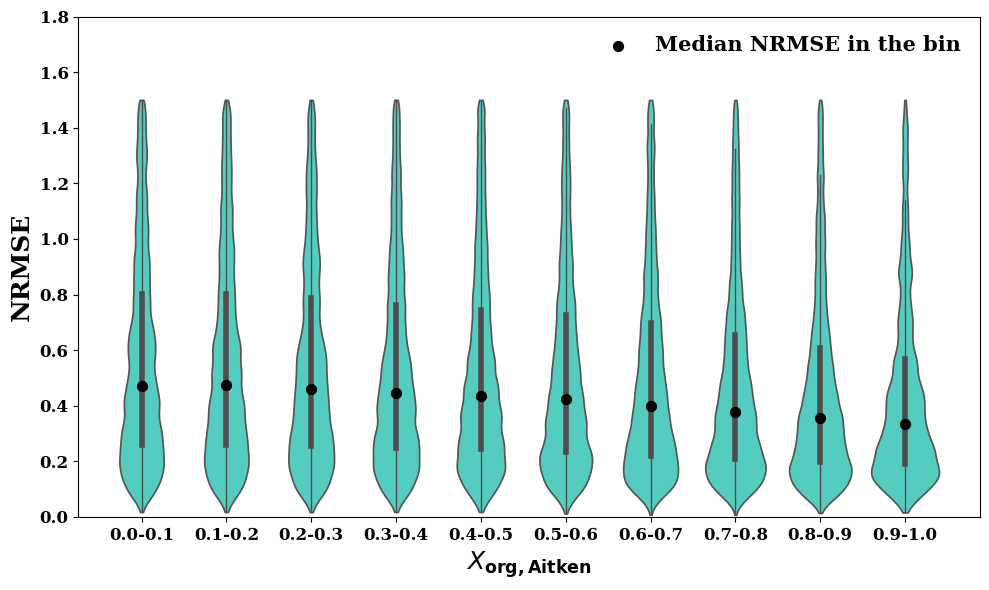

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import font_manager

all_combs = np.loadtxt('../python_version-V1/all_combinations.txt', delimiter=',') 
# Clean your data
y = all_combs[:, 0]  # NRMSE
x = all_combs[:, 1]  # mass fraction of organics in mode1

# Filter
mask = (
    np.isfinite(x) & np.isfinite(y) &
    (x <= 1) & (y <= 1.5)
)

x_clean = x[mask]
y_clean = y[mask]

# Bin x into 10 equal-width bins from 0 to 1
num_bins = 10
x_bins = np.linspace(0, 1, num_bins + 1)
x_binned = np.digitize(x_clean, x_bins, right=True)

# Label the bins
x_labels = [f"{x_bins[i]:.1f}-{x_bins[i+1]:.1f}" for i in range(num_bins)]
x_binned_labels = [x_labels[i-1] if 1 <= i <= num_bins else 'out' for i in x_binned]

# Create DataFrame for seaborn
df = pd.DataFrame({
    'Mass Fraction Bin': x_binned_labels,
    'NRMSE': y_clean
})

# Remove 'out' values
df = df[df['Mass Fraction Bin'] != 'out']

# Ensure bins are ordered correctly
df['Mass Fraction Bin'] = pd.Categorical(df['Mass Fraction Bin'], categories=x_labels, ordered=True)

# Plot violin
plt.figure(figsize=(10, 6))

# Add median line across violins
sns.violinplot(
    x = 'Mass Fraction Bin',
    y = 'NRMSE',
    data = df,
    color = 'turquoise',          # uniform solid color
    cut = 0,
    inner = 'box',              # show box inside violin
    inner_kws = dict(
        box_width = 4,         # width of the box
        whis_width = 1,         # width of whiskers
        color = ".3"            # color of the boxplot elements (e.g., light gray)
    )
)

# Compute medians for each bin
medians = df.groupby("Mass Fraction Bin")["NRMSE"].median().reindex(x_labels)

# Overlay median points
plt.scatter(
    x=np.arange(len(x_labels)),
    y=medians.values,
    color='black',
    marker='o',     # diamond marker
    s=50,           # marker size
    zorder=10,      # draw on top
    label='Median NRMSE in the bin'
)

plt.legend(
    loc='upper right',
    frameon=False,
    prop={'family': 'serif', 'weight': 'bold','size': 15}
)
#Labels and formatting
plt.ylim([0, 1.8])
plt.xlabel(r'$\mathit{X}_{\mathbf{org,Aitken}}$', fontsize=18, family='serif')
plt.ylabel('NRMSE', fontsize = 18, fontweight = 'bold', family = 'serif')
plt.xticks(rotation = 0.1, fontsize = 12, fontweight = 'bold', family = 'serif')
plt.yticks(fontsize = 12, fontweight = 'bold', family = 'serif')
plt.tight_layout()
plt.savefig('figures/paper_figures/NRMSE_violin.png', dpi = 500)
plt.show()

 <span style="color:darkblue; font-size:18px;font-weight:bold;"><i> Functions to prepare data before plotting and segregating data into seasons </i></span>  

In [9]:
def set_df(file_path):
    # Load the data from the specified file path
    df = pd.read_csv(file_path)
    # Convert the 'datetime' column to datetime format
    df['datetime'] = pd.to_datetime(df['datetime'])
    # Set 'datetime' as the index
    df.set_index('datetime', inplace = True)
    return df

def get_seasonal_data(df):
    
    df_sp = df[(df.index.month == 3)|(df.index.month == 4)|
             (df.index.month == 5)]
    df_s = df[(df.index.month == 6)|(df.index.month == 7)|
             (df.index.month == 8)]
    df_a = df[(df.index.month == 9)|(df.index.month == 10)|
             (df.index.month == 11)]
    df_w = df[(df.index.month == 12)|(df.index.month == 1)|
             (df.index.month == 2)]
    
    return [df_sp, df_s, df_a, df_w] # [Spring, summer, autumn and winter]

<span style="color:darkblue; font-size:18px;font-weight:bold;"><i> plot the seasonal observed size distribution and activation diameter </i></span> 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
#import os
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import os 

obs_dir = 'input_data/'
# Load Dp.txt file (dry particle diameter data)
with open(os.path.join(obs_dir, 'Dp.txt'), 'r') as file_dp_open:
    dp_dry = np.array([float(val) for val in file_dp_open.read().split()])

# Load datasets
nsd_file = '../../../../../../../Observation/Refine_Raw_observation/refined_raw_data/NSD_lognorm.csv'
dact_file = '../../../../../../../observed_critical_dia/observed_critical_diameter.csv'

df_NSD_lognorm = set_df(nsd_file)
df_dact_obs = set_df(dact_file)

# Function to get seasonal data
def get_seasonal_data(df):
    df_sp = df[(df.index.month == 3) | (df.index.month == 4) | (df.index.month == 5)]
    df_s = df[(df.index.month == 6) | (df.index.month == 7) | (df.index.month == 8)]
    df_a = df[(df.index.month == 9) | (df.index.month == 10) | (df.index.month == 11)]
    df_w = df[(df.index.month == 12) | (df.index.month == 1) | (df.index.month == 2)]
    return [df_sp, df_s, df_a, df_w]  # [Spring, Summer, Autumn, Winter]

# Function to calculate seasonal quantiles
def calculate_seasonal_quantiles(data):
    seasonal_data = get_seasonal_data(data)
    quantiles = [season.quantile([0.25, 0.5, 0.75]) for season in seasonal_data]
    return quantiles

# Compute quantiles for NSD and dact (critical diameter)
nsd_quantiles = calculate_seasonal_quantiles(df_NSD_lognorm)
dact_obs_quantiles = calculate_seasonal_quantiles(df_dact_obs)

# Extract 25th, 50th (median), and 75th percentiles
nsd_25, nsd_50, nsd_75 = [[q.iloc[i] for q in nsd_quantiles] for i in range(3)]
dact_obs_25, dact_obs_50, dact_obs_75 = [[q.iloc[i] for q in dact_obs_quantiles] for i in range(3)]

# Define plot settings
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
colors = ['lightseagreen', 'darkgreen', 'crimson', 'slategray']
colors_ss = ['k', 'k', 'k', 'k', 'teal']
linestyle_dact = ['-', '--', ':', '-.', '--']
labels_opt = ['0.1%', '0.2%', '0.3%', '0.5%', '1.0%']
subplot_labels = ['a.', 'b.', 'c.', 'd.']

# Create figure and subplots
fig, axs = plt.subplots(1, 4, figsize=(34, 9), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.02, hspace=0.03)

# Plot each season
for i, ax in enumerate(axs.flat):
    ax.semilogx(dp_dry, nsd_50[i], color=colors[i], linewidth=9)  # Median NSD
    ax.fill_between(dp_dry, nsd_25[i], nsd_75[i], color=colors[i], alpha=0.2)  # Shaded range
    ax.set_title(seasons[i], fontsize=25, fontweight='bold', fontname='sans-serif', y = 1.02)
    
    # Plot critical diameters as vertical lines
    for j in range(5):
        ax.axvline(x=dact_obs_50[i][j], color=colors_ss[j], linestyle=linestyle_dact[j], label=labels_opt[j], linewidth=5)

    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('sans-serif')
        label.set_fontweight('bold')
    
    # Formatting
    ax.set_xlabel('Diameter [nm]', fontsize=28, fontweight='bold', fontname='sans-serif')
    ax.tick_params(axis='both', labelsize=25, width=3, length=5)
    ax.tick_params(axis='x', which='minor', labelsize=25, width=2, length=5)
    
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2.8)
        ax.spines[axis].set_color('k')
    
    # Add subplot labels
    ax.text(0.9, 0.95, subplot_labels[i], transform=ax.transAxes, fontsize=30, fontweight='bold', fontname='sans-serif', va='top', ha='center')

# Label y-axis only on the first subplot
axs.flat[0].set_ylabel(r'dN/dlogdp [$\mathbf{cm^{-3}}$]', fontsize=28, fontweight='bold', fontname='sans-serif')
axs.flat[0].legend(fontsize=25, loc=(0.008, 0.52), frameon=False)
axs.flat[0].text(0.06, 0.97, r'D$_{act}$ [SS%]', transform=axs.flat[0].transAxes, fontsize=22, fontweight='bold', va='top')
plt.savefig('figures/paper_figures/NSD_DACT.png', dpi = 500)
# Display plot
plt.show()


<span style="color:darkblue; font-size:18px;font-weight:bold;"><i> read all CCN data </i></span>  

In [52]:
# import the functions from the fitting module

# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import ticker

#import cal_NSD as CN
import matplotlib.font_manager as font_manager

import warnings
warnings.simplefilter('ignore')
import glob

# Read predicted CCN values from the Nelder-Mead fitting results
ccn_opt_raw = pd.read_csv('result_nedler_mead_org0p12.csv')[['datetime', 'Predicted_CCN']]
# Convert 'Predicted_CCN' string values to lists of floats
ccn_opt_raw['Predicted_CCN'] = ccn_opt_raw['Predicted_CCN'].apply(lambda x: list(map(float, x.strip('[]').split())))

# Create a DataFrame for optimized CCN values with supersaturation levels (SC1 to SC5) as columns
ccn_opt = pd.DataFrame(
    ccn_opt_raw['Predicted_CCN'].tolist(), 
    index = pd.to_datetime(ccn_opt_raw['datetime']),  # Use datetime as the index
    columns=['SC1', 'SC2', 'SC3', 'SC4', 'SC5']
)

# # Read predicted Aitken CCN values from the Nelder-Mead fitting results
# ccn_opt1_raw = pd.read_csv('result_nedler_mead.csv')[['datetime', 'predicted_CCN1']]
# # Convert 'Predicted_CCN' string values to lists of floats
# ccn_opt1_raw['predicted_CCN1'] = ccn_opt1_raw['predicted_CCN1'].apply(lambda x: list(map(float, x.strip('[]').split())))

# # Create a DataFrame for optimized CCN values with supersaturation levels (SC1 to SC5) as columns
# ccn_opt1 = pd.DataFrame(
#     ccn_opt1_raw['predicted_CCN1'].tolist(), 
#     index=pd.to_datetime(ccn_opt1_raw['datetime']),  # Use datetime as the index
#     columns=['SC1', 'SC2', 'SC3', 'SC4', 'SC5']
# )

# # Read predicted accumulation CCN values from the Nelder-Mead fitting results
# ccn_opt2_raw = pd.read_csv('result_nedler_mead.csv')[['datetime', 'predicted_CCN2']]
# # Convert 'Predicted_CCN' string values to lists of floats
# ccn_opt2_raw['predicted_CCN2'] = ccn_opt2_raw['predicted_CCN2'].apply(lambda x: list(map(float, x.strip('[]').split())))

# # Create a DataFrame for optimized CCN values with supersaturation levels (SC1 to SC5) as columns
# ccn_opt2 = pd.DataFrame(
#     ccn_opt2_raw['predicted_CCN2'].tolist(), 
#     index=pd.to_datetime(ccn_opt2_raw['datetime']),  # Use datetime as the index
#     columns=['SC1', 'SC2', 'SC3', 'SC4', 'SC5']
# )
# predicted CCN using chemical composition data
CCN_ACSM_raw = pd.read_csv('CCN_ACSM_eBC.csv')[['datetime', 'Predicted_CCN_ACSM']]
CCN_ACSM_raw['Predicted_CCN_ACSM'] = CCN_ACSM_raw['Predicted_CCN_ACSM'].apply(lambda x: list(map(float, x.strip('[]').split())))
# Create a DataFrame for optimized CCN values with supersaturation levels (SC1 to SC5) as columns
CCN_ACSM = pd.DataFrame(
    CCN_ACSM_raw['Predicted_CCN_ACSM'].tolist(), 
    index = pd.to_datetime(CCN_ACSM_raw['datetime']),  # Use datetime as the index
    columns=['SC1', 'SC2', 'SC3', 'SC4', 'SC5']
)
# CCN when kappa = 0.18
CCN_sihto_raw = pd.read_csv('CCN_Sihto.csv')[['datetime', 'Predicted_CCN_Sihto']]
CCN_sihto_raw['Predicted_CCN_Sihto'] = CCN_sihto_raw['Predicted_CCN_Sihto'].apply(lambda x: list(map(float, x.strip('[]').split())))
# Create a DataFrame for optimized CCN values with supersaturation levels (SC1 to SC5) as columns
CCN_sihto = pd.DataFrame(
    CCN_sihto_raw['Predicted_CCN_Sihto'].tolist(), 
    index = pd.to_datetime(CCN_sihto_raw['datetime']),  # Use datetime as the index
    columns=['SC1', 'SC2', 'SC3', 'SC4', 'SC5']
)
# predicted CCN when organic Kappa is zero
CCN_org_zero_raw = pd.read_csv('CCN_ACSM_eBC_no_org_kappa.csv')[['datetime', 'Predicted_CCN_ACSM']]
CCN_org_zero_raw['Predicted_CCN_ACSM'] = CCN_org_zero_raw['Predicted_CCN_ACSM'].apply(lambda x: list(map(float, x.strip('[]').split())))
# Create a DataFrame for optimized CCN values with supersaturation levels (SC1 to SC5) as columns
CCN_org_zero = pd.DataFrame(
    CCN_org_zero_raw['Predicted_CCN_ACSM'].tolist(), 
    index = pd.to_datetime(CCN_org_zero_raw['datetime']),  # Use datetime as the index
    columns=['SC1', 'SC2', 'SC3', 'SC4', 'SC5']
)

# observed CCN data
CCN_obs = set_df('input_data/CCN.csv')

# Harmonizing all CCN data using intersection of indices
common_index = CCN_obs.index
for df in [CCN_sihto, CCN_ACSM, ccn_opt, CCN_org_zero]:
    common_index = common_index.intersection(df.index)

# Subset each DataFrame to the common index
CCN_sihto_harmonized = CCN_sihto.loc[common_index]
CCN_ACSM_harmonized = CCN_ACSM.loc[common_index]
ccn_opt_harmonized = ccn_opt.loc[common_index]
CCN_org_zero_harmonized = CCN_org_zero.loc[common_index]
CCN_obs_harmonized = CCN_obs.loc[common_index]

<span style="color:darkblue; font-size:18px;font-weight:bold;"><i> plot CCN conc monthly cycle </i></span>  

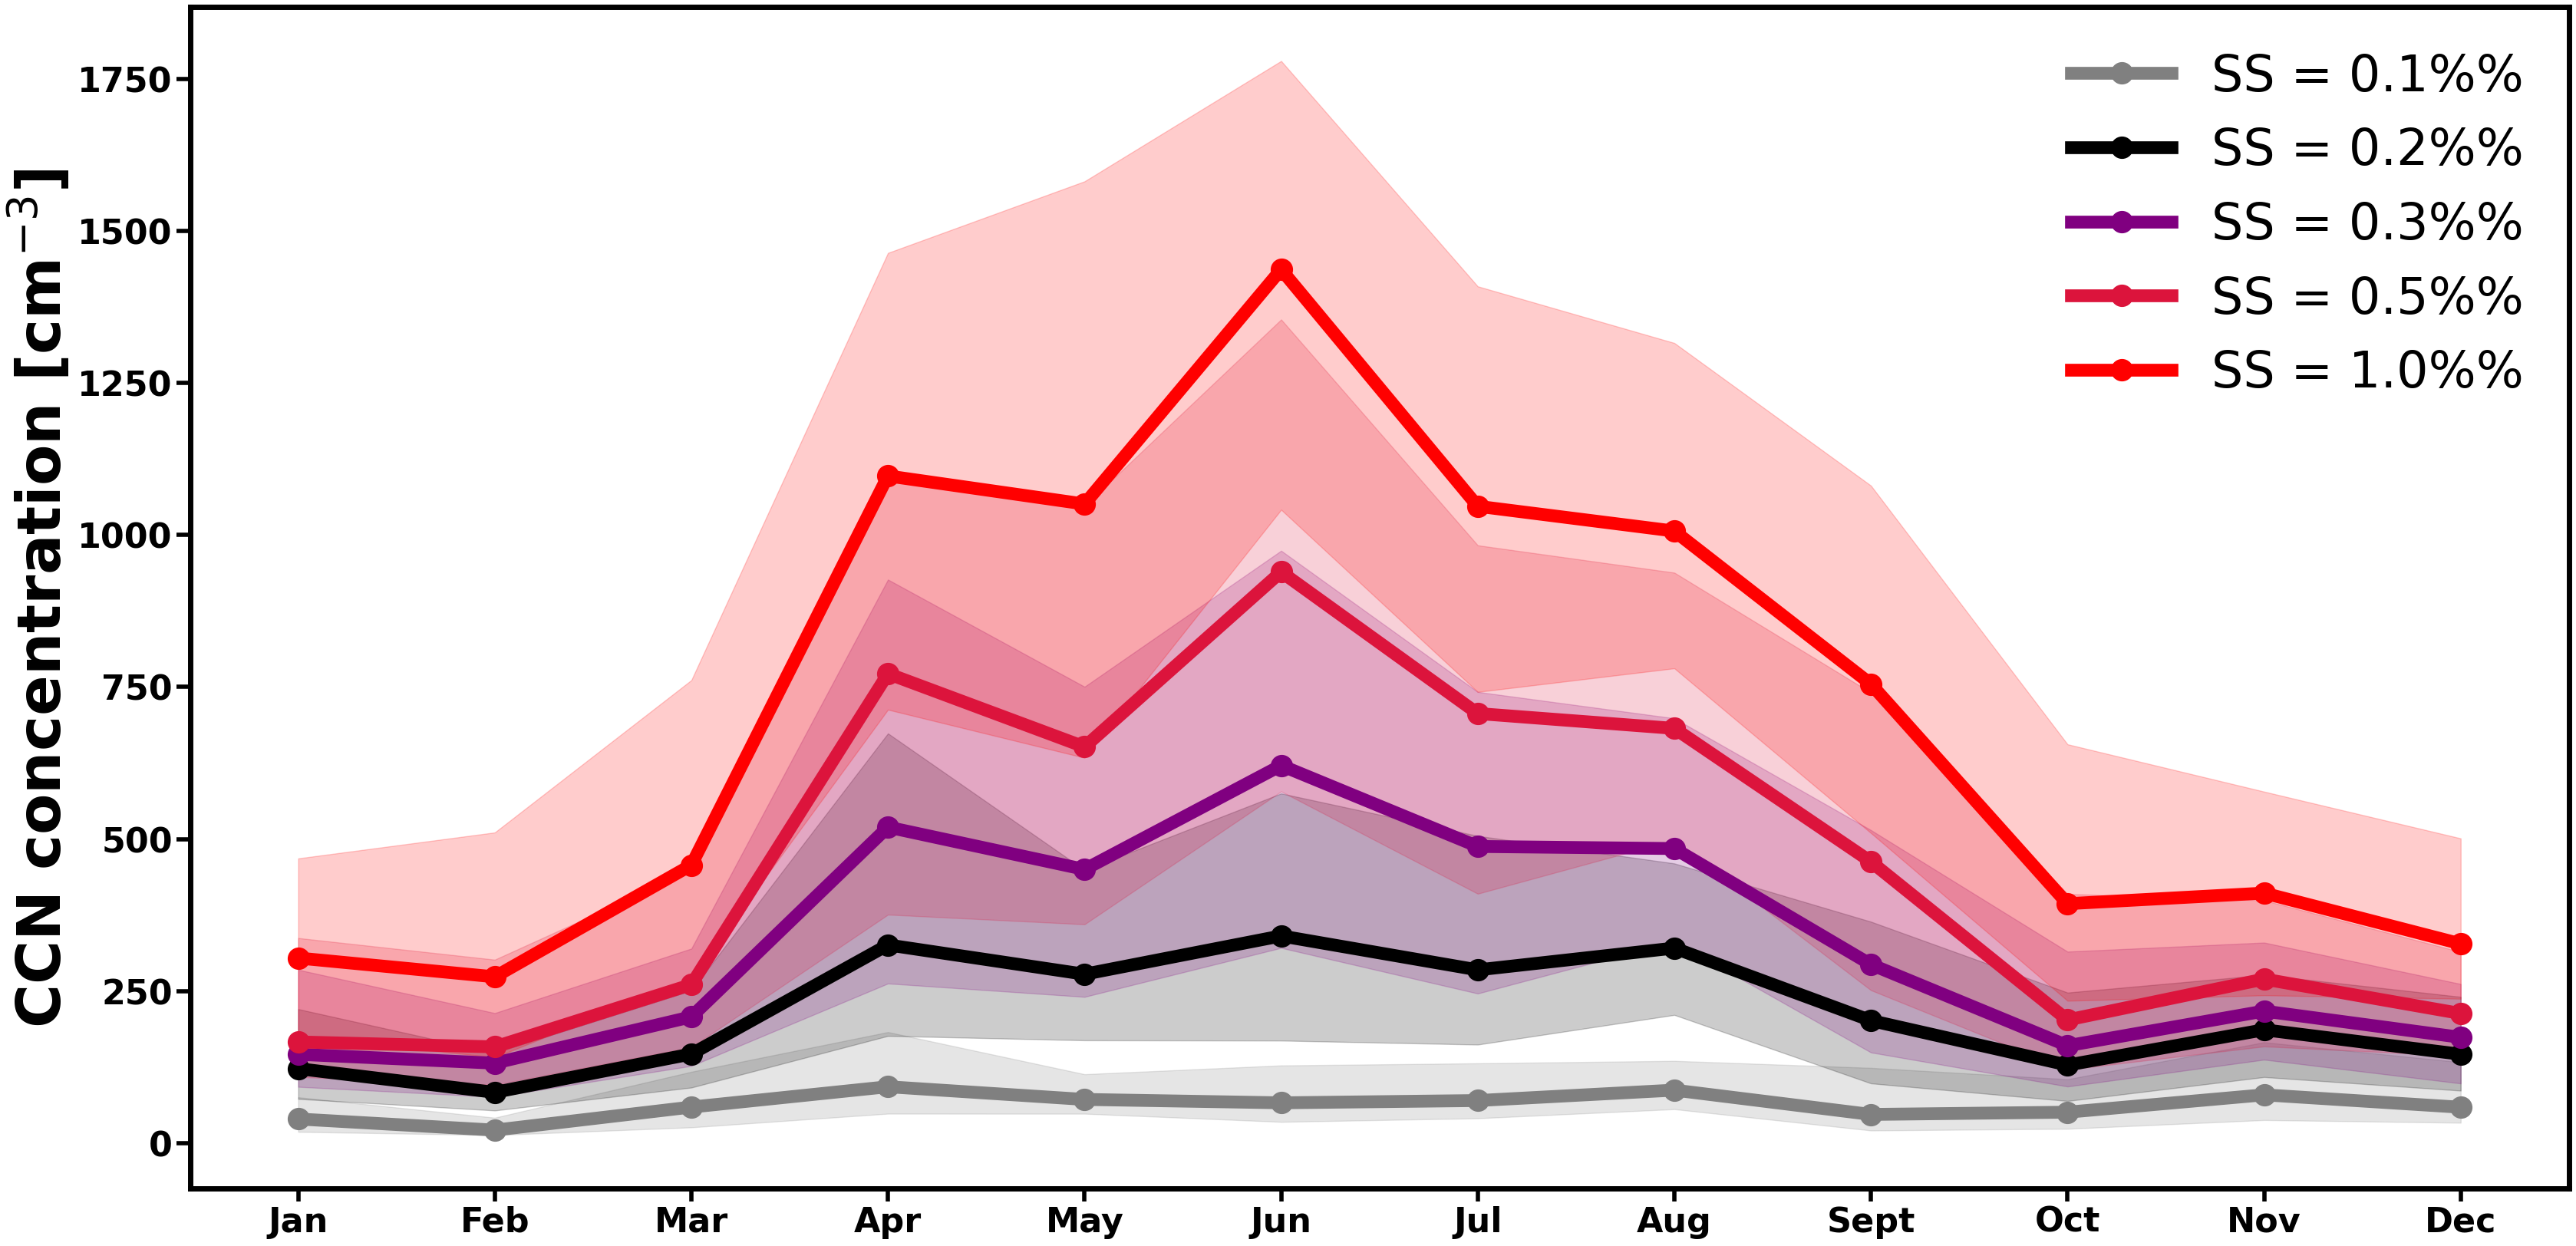

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_CCN_obs is a DataFrame with a DateTime index
# df_CCN_obs = pd.read_csv('your_data.csv', index_col='datetime', parse_dates=True)

# Generate the lists of monthly statistics
monthly_medians_ls = []
monthly_25_ls = []
monthly_75_ls = []
for i in range(1, 13):
    monthly_medians = CCN_obs_harmonized[CCN_obs_harmonized.index.month == i].median()
    monthly_lower = CCN_obs_harmonized[CCN_obs_harmonized.index.month == i].quantile(0.25)
    monthly_upper = CCN_obs_harmonized[CCN_obs_harmonized.index.month == i].quantile(0.75)
    
    monthly_medians_ls.append(monthly_medians.tolist())
    monthly_25_ls.append(monthly_lower.tolist())
    monthly_75_ls.append(monthly_upper.tolist())

# Define colors and labels
colors = ['grey', 'black', 'purple', 'crimson', 'red', 'red']
x_ticks = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
ss = ['0.1%', '0.2%', '0.3%', '0.5%', '1.0%']

# Create the plot
fig, ax1 = plt.subplots(1, 1, figsize=(40, 20), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.03, hspace=0.02)

# Plot each supersaturation level with markers
for idx, color in enumerate(colors[:5]):  # Loop over the first five colors
    ax1.plot(x_ticks, [sublist[idx] for sublist in monthly_medians_ls], 
             color=color, linewidth=12, marker='o', markersize=20, label=f'SS = {ss[idx]}%')
    ax1.fill_between(x_ticks, [sublist[idx] for sublist in monthly_25_ls], 
                     [sublist[idx] for sublist in monthly_75_ls], alpha=0.2, color=color)

# Set font properties for tick labels
for tick in ax1.get_xticklabels():
    tick.set_fontname("sans-serif")
    tick.set_fontweight("bold")

for tick in ax1.get_yticklabels():
    tick.set_fontname("sans-serif")
    tick.set_fontweight("bold")

# Set the axis properties
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(5)
    ax1.spines[axis].set_color('k')

# Set the ylabel with LaTeX formatting
ax1.set_ylabel(r'CCN concentration [cm$^{-3}$]', fontsize=56, fontweight='bold', fontname='sans-serif')

# Set tick parameters
ax1.tick_params(axis='y', length=13, labelsize=32, width=4)
ax1.tick_params(axis='x', length=12, labelsize=32, width=4)

# Set legend properties
ax1.legend(frameon=False, prop={'size': 47, 'family': 'sans-serif'})

# Save the figure
plt.savefig('figures/paper_figures/monthly_Observed_CCN.png', dpi=500)

# Show the plot
plt.show()


<span style="color:darkblue; font-size:18px;font-weight:bold;"><i> plot CCN spectra </i></span>  

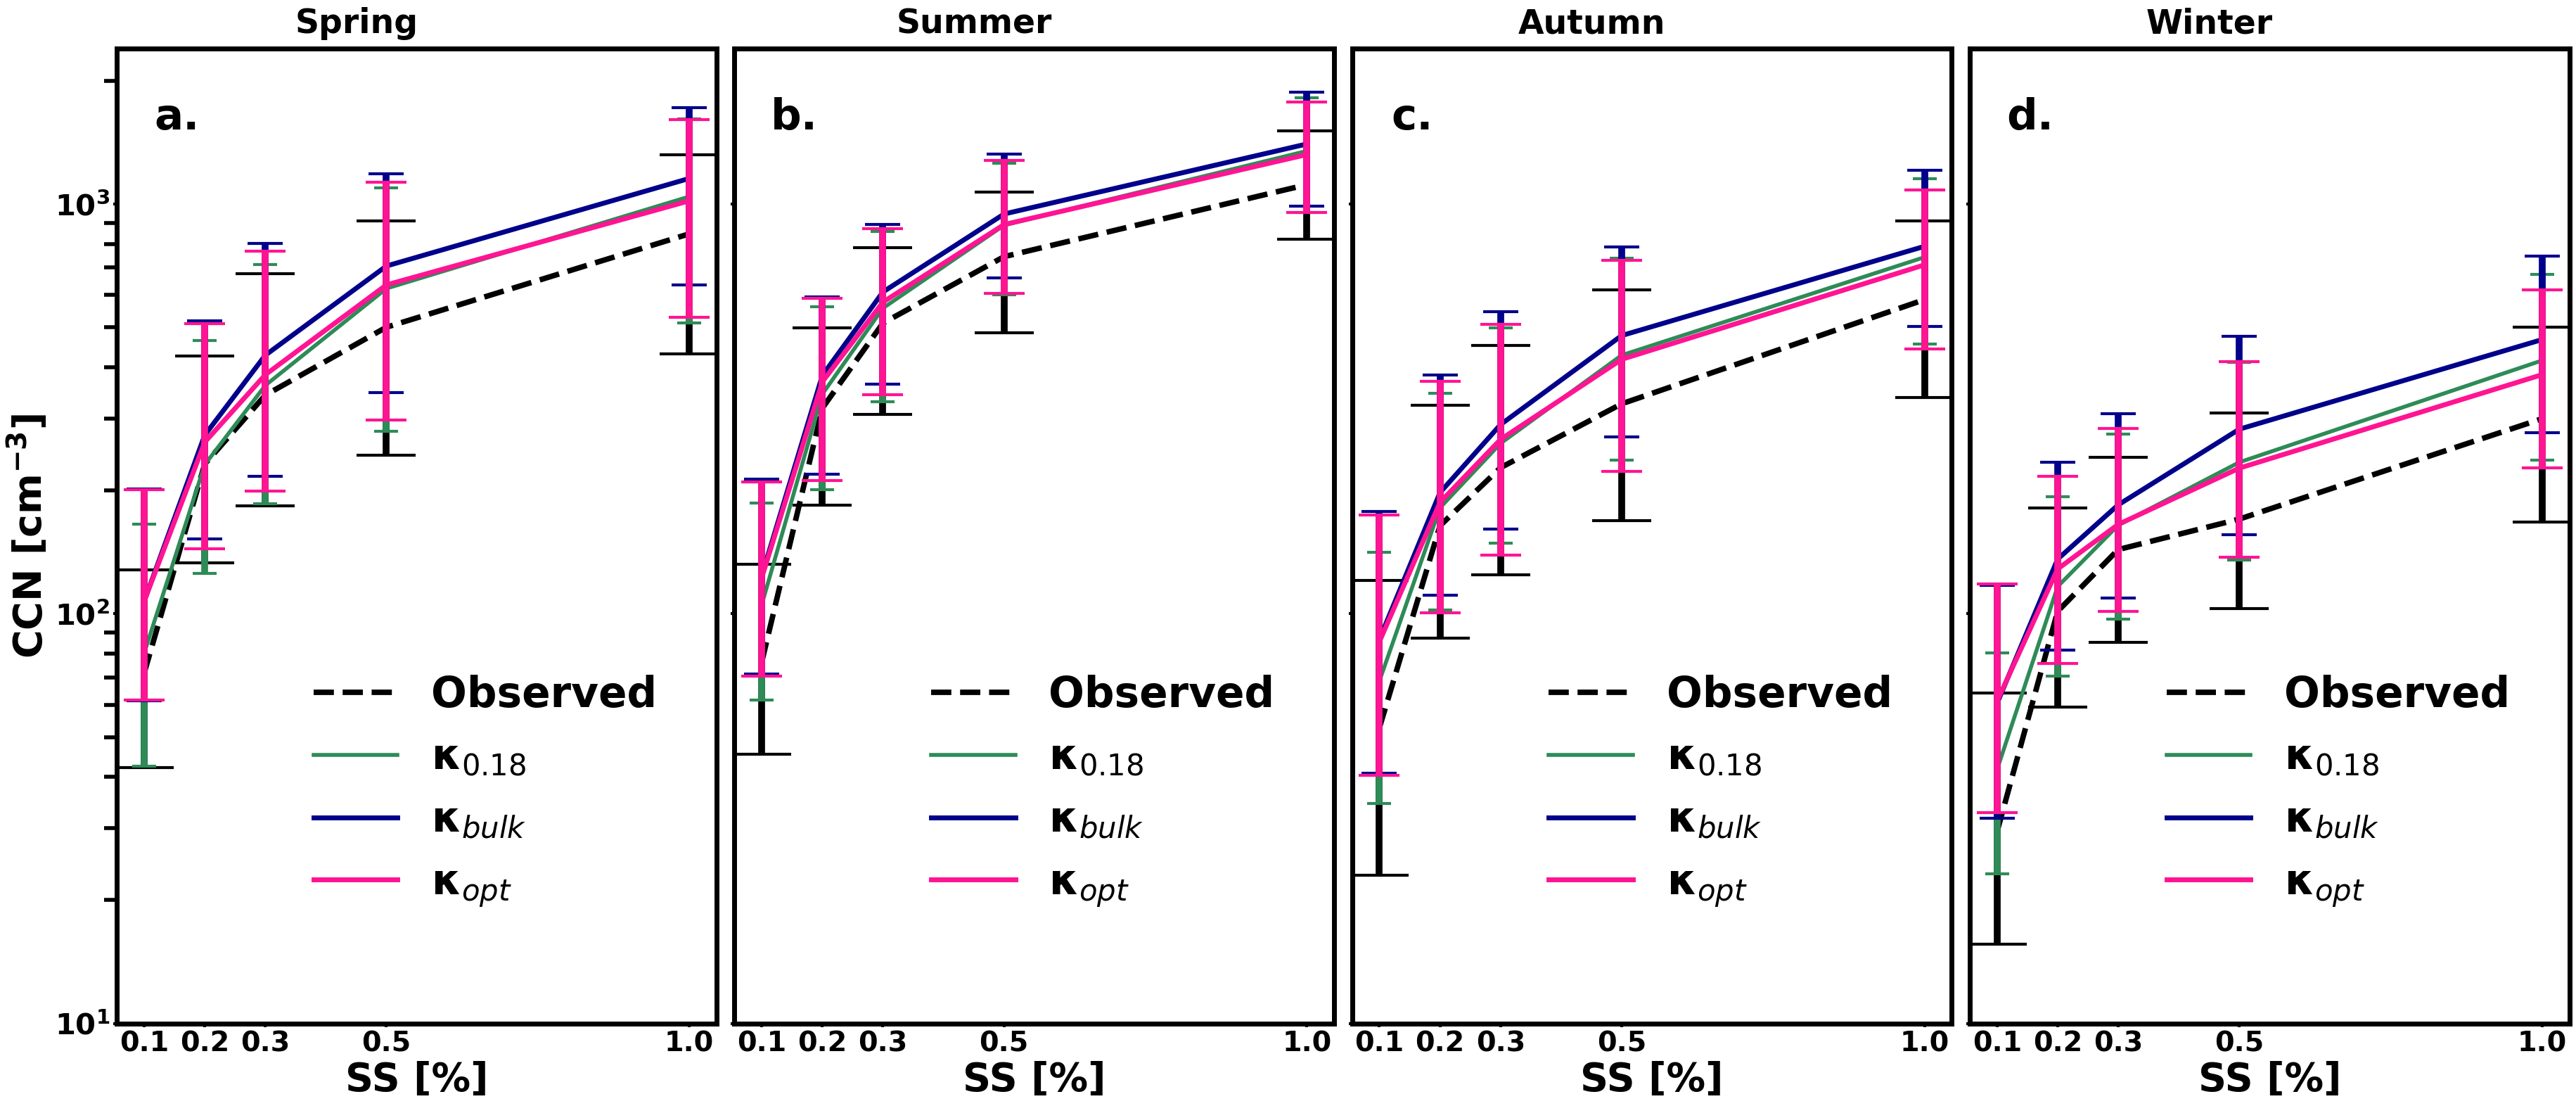

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Get seasonal data
seasons = ['sp', 's', 'a', 'w']
df_CCN_obs_ls = [get_seasonal_data(CCN_obs_harmonized)[i] for i in range(4)]
df_CCN_opt_ls = [get_seasonal_data(ccn_opt_harmonized)[i] for i in range(4)]
df_CCN_ACSM_BC_ls = [get_seasonal_data(CCN_ACSM_harmonized)[i] for i in range(4)]
df_CCN_sihto_ls = [get_seasonal_data(CCN_sihto_harmonized)[i] for i in range(4)]
df_CCN_no_org_kappa_ls = [get_seasonal_data(CCN_org_zero_harmonized)[i] for i in range(4)]

# Calculate quantiles for all seasons and dataframes
def calculate_quantiles(df_list):
    quantiles_25 = [df.quantile(0.25) for df in df_list]
    quantiles_50 = [df.quantile(0.5) for df in df_list]
    quantiles_75 = [df.quantile(0.75) for df in df_list]
    return quantiles_25, quantiles_50, quantiles_75

df_CCN_obs_25, df_CCN_obs_50, df_CCN_obs_75 = calculate_quantiles(df_CCN_obs_ls)
df_CCN_opt_25, df_CCN_opt_50, df_CCN_opt_75 = calculate_quantiles(df_CCN_opt_ls)
df_CCN_ACSM_BC_25, df_CCN_ACSM_BC_50, df_CCN_ACSM_BC_75 = calculate_quantiles(df_CCN_ACSM_BC_ls)
df_CCN_sihto_25, df_CCN_sihto_50, df_CCN_sihto_75 = calculate_quantiles(df_CCN_sihto_ls)
df_CCN_no_org_kappa_25, df_CCN_no_org_kappa_50, df_CCN_no_org_kappa_75 = calculate_quantiles(df_CCN_no_org_kappa_ls)

# Plotting
ss = [0.1, 0.2, 0.3, 0.5, 1.0]
colors = ['black', 'seagreen', 'darkblue', 'deeppink', 'cyan']
#colors = ['#000000', '#0072B2', '#D55E00', '#009E73', '#CC79A7']

fig, axs = plt.subplots(1, 4, figsize=(45, 18), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.03, hspace=0.03)

seasons = ['Spring', 'Summer', 'Autumn', 'Winter']

# Plot data for each season
for j, season in enumerate(seasons):
    ax = axs[j]
    ax.semilogy(ss, df_CCN_obs_50[j], linestyle='--', color=colors[0], linewidth=5.6, label='Observed')
    ax.errorbar(ss, df_CCN_obs_50[j], yerr=[df_CCN_obs_50[j] - df_CCN_obs_25[j], df_CCN_obs_75[j] - df_CCN_obs_50[j]],
                fmt='none', ecolor=colors[0], capsize=30, capthick=3, linewidth=7)
    
    ax.semilogy(ss, df_CCN_sihto_50[j], linestyle='-', color=colors[1], linewidth=4, label=r'$\mathbf{\kappa}_{0.18}$')
    ax.errorbar(ss, df_CCN_sihto_50[j], yerr=[df_CCN_sihto_50[j] - df_CCN_sihto_25[j], df_CCN_sihto_75[j] - df_CCN_sihto_50[j]],
                fmt='none', ecolor=colors[1], capsize=12, capthick=3, linewidth=7)
    
    ax.semilogy(ss, df_CCN_ACSM_BC_50[j], linestyle='-', color=colors[2], linewidth=5, label=r'$\mathbf{\kappa}_{bulk}$')
    ax.errorbar(ss, df_CCN_ACSM_BC_50[j], yerr=[df_CCN_ACSM_BC_50[j] - df_CCN_ACSM_BC_25[j], df_CCN_ACSM_BC_75[j] - df_CCN_ACSM_BC_50[j]],
                fmt='none', ecolor=colors[2], capsize=18, capthick=3, linewidth=7)
    
    ax.semilogy(ss, df_CCN_opt_50[j], linestyle='-', color=colors[3], linewidth=5, label=r'$\mathbf{\kappa}_{opt}$')
    ax.errorbar(ss, df_CCN_opt_50[j], yerr=[df_CCN_opt_50[j] - df_CCN_opt_25[j], df_CCN_opt_75[j] - df_CCN_opt_50[j]],
                fmt = 'none', ecolor=colors[3], capsize = 21, capthick = 3, linewidth = 7)

    # ax.semilogy(ss, df_CCN_no_org_kappa_50[j], linestyle='-', color=colors[4], linewidth=5, label=r'$\mathbf{\kappa}_{org} = 0$')
    # ax.errorbar(ss, df_CCN_no_org_kappa_50[j], yerr=[df_CCN_no_org_kappa_50[j] - df_CCN_no_org_kappa_25[j], df_CCN_no_org_kappa_75[j] - df_CCN_no_org_kappa_50[j]],
    #             fmt = 'none', ecolor=colors[4], capsize = 21, capthick = 3, linewidth = 5)
    
    ax.set_title(season, fontsize=34, fontweight='bold', x=0.4, y=1.01)
    ax.set_ylim([10, 2400])
    # Add subplot label (a., b., c., d.)
    subplot_labels = ['a.', 'b.', 'c.', 'd.']  # Labels for subplots
    ax.text(0.1, 0.95, subplot_labels[j], transform=ax.transAxes, fontsize=44, 
            fontweight='bold', fontname='sans-serif', va='top', ha='center')


# Set ylabel for the first subplot
axs[0].set_ylabel(r'CCN $\mathbf{[cm^{-3}]}$', fontsize=40, fontweight='bold', fontname='sans-serif')

# Customize axes
for ax in axs.flat:
    for tick in ax.get_xticklabels() + ax.get_yticklabels():
        tick.set_fontname('sans-serif')
        tick.set_fontweight('bold')
    
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(5)
        ax.spines[axis].set_color('k')
    
    ax.tick_params(axis='y', labelsize=30, width=3)
    ax.tick_params(axis='x', labelsize=28.6, width=3)
    axs[0].tick_params(axis='y', which='minor', length=13, width=4, direction='out')
    ax.set_xticks(ss)

for ax in axs:
    ax.set_xlabel('SS [%]', fontsize=40, fontweight='bold', fontname='sans-serif')

# Add the legend to each subplot
for ax in axs.flat:
    ax.legend(loc=(0.3, 0.1), fontsize=35, prop={'family': 'sans-serif', 'weight': 'bold', 'size': 43}, frameon=False)

# Save and show the plot
plt.savefig('figures/paper_figures/CCN_spectra.png', dpi = 500)
plt.show()


<span style="font-size:18px; color:darkblue; font-weight:bold;">  <i>percentiles of observed CCN<i></span> 

In [58]:
# Print the quantiles for each season
def print_quantiles_for_season(season_name, quantiles_25, quantiles_50, quantiles_75):
    print(f"{season_name} Percentiles:")
    print("25th Percentile:\n", quantiles_25)
    print("50th Percentile (Median):\n", quantiles_50)
    print("75th Percentile:\n", quantiles_75)
    print("\n")

# Loop through each season and print the quantiles
seasons_full = ['Spring', 'Summer', 'Autumn', 'Winter']
for i, season_name in enumerate(seasons_full):
    print(f"---- {season_name} Percentiles ----")
    print_quantiles_for_season(
        season_name,
        df_CCN_obs_25[i],
        df_CCN_obs_50[i],
        df_CCN_obs_75[i]
    )


---- Spring Percentiles ----
Spring Percentiles:
25th Percentile:
 SC1     42.1700
SC2    133.3600
SC3    183.1000
SC4    243.6500
SC5    430.6875
Name: 0.25, dtype: float64
50th Percentile (Median):
 SC1     71.575
SC2    231.955
SC3    341.705
SC4    500.685
SC5    846.230
Name: 0.5, dtype: float64
75th Percentile:
 SC1     127.8250
SC2     425.9275
SC3     676.0225
SC4     910.8275
SC5    1318.5525
Name: 0.75, dtype: float64


---- Summer Percentiles ----
Summer Percentiles:
25th Percentile:
 SC1     45.3425
SC2    183.8225
SC3    306.6450
SC4    484.7700
SC5    820.8425
Name: 0.25, dtype: float64
50th Percentile (Median):
 SC1      76.305
SC2     317.790
SC3     512.315
SC4     744.315
SC5    1115.690
Name: 0.5, dtype: float64
75th Percentile:
 SC1     131.9900
SC2     498.5175
SC3     782.6800
SC4    1071.5900
SC5    1508.8675
Name: 0.75, dtype: float64


---- Autumn Percentiles ----
Autumn Percentiles:
25th Percentile:
 SC1     22.98
SC2     87.38
SC3    124.28
SC4    169.00
SC5 

<span style="color:darkblue; font-size:18px;font-weight:bold;"><i> define functions that calculate NRMSE and GMB </i></span>  

In [109]:
import numpy as np

import numpy as np

def remove_outliers(df):
    """
    Removes outliers from a DataFrame using the Interquartile Range (IQR) method.

    Outliers are defined as values below Q1 - 1.5*IQR or above Q3 + 1.5*IQR.
    This method is based on:
    
    Tukey, J. W. (1977). Exploratory Data Analysis. Addison-Wesley.

    Parameters:
    df (DataFrame): The input DataFrame containing numerical data.

    Returns:
    DataFrame: A copy of the DataFrame with outliers replaced by NaN.
    """
    clean_df = df.copy()
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        clean_df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), np.nan, df[col])
    
    return clean_df

def cal_nrmse(obs, pred):
    """
    Calculate the Normalized Root Mean Square Error (NRMSE) after removing outliers.

    This function first filters out outliers using the IQR method before computing NRMSE.

    Parameters:
    obs (DataFrame): Observed values with the same length and column names as pred.
    pred (DataFrame): Predicted values with the same length and column names as obs.

    Returns:
    float: The NRMSE value.
    """
    # Filter for data from 2016 onward
    obs_2016 = obs[obs.index.year > 2015]
    pred_2016 = pred[pred.index.year > 2015]

    # Remove outliers from both observed and predicted data
    obs_2016_clean = remove_outliers(obs_2016)
    pred_2016_clean = remove_outliers(pred_2016)

    # Ensure both DataFrames have the same valid index after outlier removal
    valid_index = obs_2016_clean.dropna().index.intersection(pred_2016_clean.dropna().index)
    obs_2016_clean = obs_2016_clean.loc[valid_index]
    pred_2016_clean = pred_2016_clean.loc[valid_index]

    # Compute RMSE
    rmse = np.sqrt(((pred_2016_clean - obs_2016_clean) ** 2).mean())

    # Normalize by the mean of the observed values
    mean_obs = obs_2016_clean.mean()
    nrmse = rmse / mean_obs

    return nrmse

def cal_combined_nrmse(obs, pred):
    """
    Calculate the combined NRMSE across all supersaturations (SS),
    normalizing by the mean CCN of a particular time step, and then
    take the median NRMSE across all time steps.

    Parameters:
    obs (DataFrame): Observed CCN values (columns = SS levels, index = time).
    pred (DataFrame): Predicted CCN values (same shape as obs).

    Returns:
    float: The median combined NRMSE across all time steps.
    """
    # Remove outliers
    obs_clean = remove_outliers(obs)
    pred_clean = remove_outliers(pred)
    
    # Ensure the dataframes have the same valid indices
    valid_index = obs_clean.dropna().index.intersection(pred_clean.dropna().index)
    obs_clean = obs_clean.loc[valid_index]
    pred_clean = pred_clean.loc[valid_index]
    
    # Compute RMSE for each time step (row-wise RMSE)
    rmse_per_time = np.sqrt(((pred_clean - obs_clean) ** 2).mean(axis=1))
    
    # Normalize by the mean CCN of the corresponding time step
    mean_ccn_per_time = obs_clean.mean(axis=1)
    nrmse_per_time = rmse_per_time / mean_ccn_per_time
    
    # Return the median NRMSE across all time steps
    return nrmse_per_time.median()

def cal_corr(obs, pred):
    """
    Calculate the correlation between observed and predicted CCN values after removing outliers.

    Parameters:
    obs (DataFrame): Observed values with the same length and column names as pred.
    pred (DataFrame): Predicted values with the same length and column names as obs.

    Returns:
    Series: Correlation values between the corresponding columns of observed and predicted data.
    """
    # Remove outliers
    obs_clean = remove_outliers(obs)
    pred_clean = remove_outliers(pred)

    # Ensure alignment of valid (non-NaN) indices
    valid_index = obs_clean.dropna().index.intersection(pred_clean.dropna().index)
    obs_clean = obs_clean.loc[valid_index]
    pred_clean = pred_clean.loc[valid_index]

    # Compute correlation
    corr = obs_clean.corrwith(pred_clean)
    
    return corr

import numpy as np

def cal_bias(obs, pred):
    """
    Calculate the geometric mean ratio (bias) between observed and predicted CCN values after removing outliers.

    Parameters:
    obs (DataFrame): Observed values with the same length and column names as pred.
    pred (DataFrame): Predicted values with the same length and column names as obs.

    Returns:
    float: The geometric mean ratio (bias).
    """
    # Filter for data from 2016 onward
    obs_2016 = obs[obs.index.year > 2015]
    pred_2016 = pred[pred.index.year > 2015]

    # Remove outliers
    obs_2016_clean = remove_outliers(obs_2016)
    pred_2016_clean = remove_outliers(pred_2016)

    # Ensure alignment of valid (non-NaN) indices
    valid_index = obs_2016_clean.dropna().index.intersection(pred_2016_clean.dropna().index)
    obs_2016_clean = obs_2016_clean.loc[valid_index]
    pred_2016_clean = pred_2016_clean.loc[valid_index]

    # Avoid division by zero
    obs_2016_clean = obs_2016_clean.replace(0, np.nan).dropna()
    pred_2016_clean = pred_2016_clean.loc[obs_2016_clean.index]  # Align again

    # Calculate the ratio of predicted to observed values
    ccn_ratio = pred_2016_clean / obs_2016_clean

    # Handle cases where ratio is zero or negative
    ccn_ratio = ccn_ratio[ccn_ratio > 0].dropna()

    # Compute geometric mean ratio
    if len(ccn_ratio) == 0:
        return np.nan  # Return NaN if no valid data remains

    geometric_mean_ratio = np.exp(np.log(ccn_ratio).mean())

    return geometric_mean_ratio


In [60]:
CCN_obs_harmonized_filt = CCN_obs_harmonized
CCN_ACSM_harmonized_filt = pd.concat([CCN_ACSM_harmonized, CCN_obs_harmonized_filt], axis = 1).dropna().iloc[:,0:5]
CCN_sihto_harmonized_filt= pd.concat([CCN_sihto_harmonized, CCN_obs_harmonized_filt], axis = 1).dropna().iloc[:,0:5]
CCN_org_zero_harmonized_filt= pd.concat([CCN_org_zero_harmonized, CCN_obs_harmonized_filt], axis = 1).dropna().iloc[:,0:5]
ccn_opt_harmonized_filt= pd.concat([ccn_opt_harmonized, CCN_obs_harmonized_filt], axis = 1).dropna().iloc[:,0:5]

In [61]:
# Calculate combined NRMSEs across all SS levels
NRMSE_ACSM_BC = cal_combined_nrmse(CCN_obs_harmonized, CCN_ACSM_harmonized_filt)
NRMSE_sihto = cal_combined_nrmse(CCN_obs_harmonized, CCN_sihto_harmonized_filt)
NRMSE_opt = cal_combined_nrmse(CCN_obs_harmonized, ccn_opt_harmonized_filt)
NRMSE_no_org_kappa = cal_combined_nrmse(CCN_obs_harmonized, CCN_org_zero_harmonized_filt)

# Print the results
print(f"Combined NRMSE (ACSM_BC): {NRMSE_ACSM_BC:.4f}")
print(f"Combined NRMSE (Sihto): {NRMSE_sihto:.4f}")
print(f"Combined NRMSE (Opt): {NRMSE_opt:.4f}")
print(f"Combined NRMSE (No Org Kappa): {NRMSE_no_org_kappa:.4f}")

Combined NRMSE (ACSM_BC): 0.4343
Combined NRMSE (Sihto): 0.3532
Combined NRMSE (Opt): 0.2775
Combined NRMSE (No Org Kappa): 0.3688


<span style="color:darkblue; font-size:18px;font-weight:bold;"><i> Calculate NRMSE and plot them </i></span>  

NRMSE (Bulk composition - SS 0.1%) = 0.940 (Correlation = 0.781)
NRMSE (Bulk composition - SS 0.2%) = 0.495 (Correlation = 0.847)
NRMSE (Bulk composition - SS 0.3%) = 0.486 (Correlation = 0.851)
NRMSE (Bulk composition - SS 0.5%) = 0.591 (Correlation = 0.837)
NRMSE (Bulk composition - SS 1.0%) = 0.596 (Correlation = 0.787)
NRMSE (Sihto - SS 0.1%) = 0.714 (Correlation = 0.744)
NRMSE (Sihto - SS 0.2%) = 0.429 (Correlation = 0.845)
NRMSE (Sihto - SS 0.3%) = 0.420 (Correlation = 0.858)
NRMSE (Sihto - SS 0.5%) = 0.498 (Correlation = 0.852)
NRMSE (Sihto - SS 1.0%) = 0.524 (Correlation = 0.807)
NRMSE (Optimized - SS 0.1%) = 0.927 (Correlation = 0.779)
NRMSE (Optimized - SS 0.2%) = 0.461 (Correlation = 0.856)
NRMSE (Optimized - SS 0.3%) = 0.427 (Correlation = 0.871)
NRMSE (Optimized - SS 0.5%) = 0.470 (Correlation = 0.878)
NRMSE (Optimized - SS 1.0%) = 0.442 (Correlation = 0.859)
NRMSE (Org_kappa = 0 - SS 0.1%) = 0.623 (Correlation = 0.699)
NRMSE (Org_kappa = 0 - SS 0.2%) = 0.495 (Correlation 

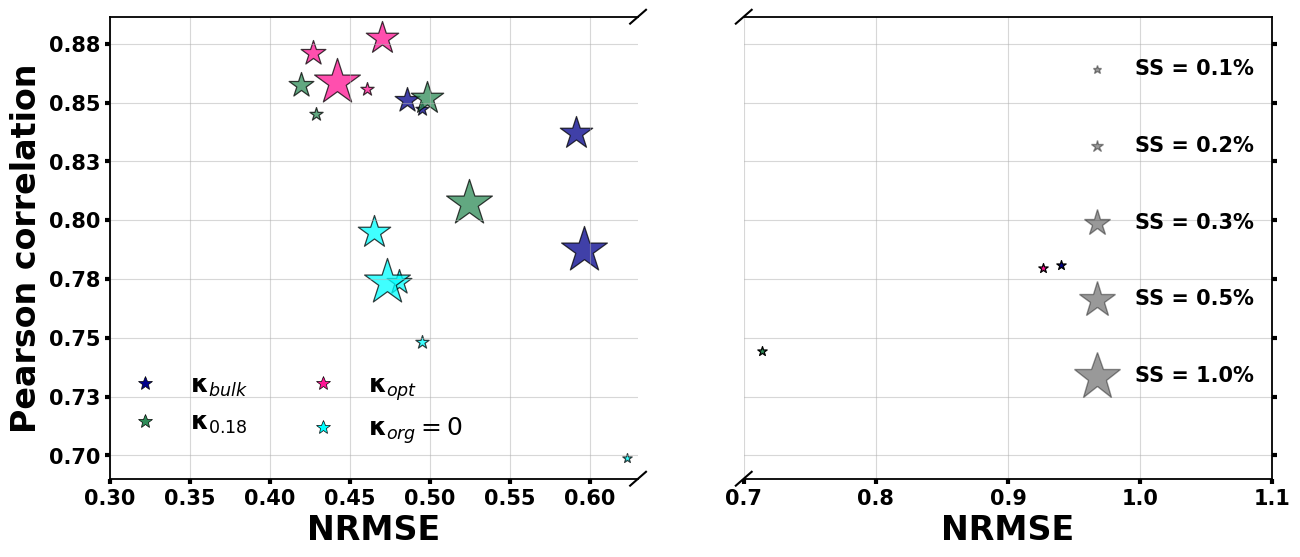

In [62]:
# Calculate NRMSEes and correlations
NRMSE_ACSM_BC = cal_nrmse(CCN_obs_harmonized, CCN_ACSM_harmonized_filt)
NRMSE_sihto = cal_nrmse(CCN_obs_harmonized, CCN_sihto_harmonized_filt)
NRMSE_opt = cal_nrmse(CCN_obs_harmonized, ccn_opt_harmonized_filt)
NRMSE_no_org_kappa = cal_nrmse(CCN_obs_harmonized, CCN_org_zero_harmonized_filt)

corr_ACSM_BC = cal_corr(CCN_obs_harmonized, CCN_ACSM_harmonized_filt)
corr_sihto = cal_corr(CCN_obs_harmonized, CCN_sihto_harmonized_filt)
corr_opt = cal_corr(CCN_obs_harmonized, ccn_opt_harmonized_filt)
corr_no_org_kappa = cal_corr(CCN_obs_harmonized, CCN_org_zero_harmonized_filt)

NRMSE = [NRMSE_ACSM_BC, NRMSE_sihto, NRMSE_opt, NRMSE_no_org_kappa]
corrs = [corr_ACSM_BC, corr_sihto, corr_opt, corr_no_org_kappa]

ss_levels = [0.1, 0.2, 0.3, 0.5, 1.0]
# Print the NRMSE and correlation values
methods = ['Bulk composition', 'Sihto', 'Optimized', 'Org_kappa = 0']
for i in range(len(NRMSE)):
    for j in range(len(NRMSE[i])):
        print(f"NRMSE ({methods[i]} - SS {ss_levels[j]}%) = {NRMSE[i][j]:.3f} (Correlation = {corrs[i][j]:.3f})")
# Compute the mean NRMSE across all SS
avg_NRMSE_ACSM_BC = NRMSE_ACSM_BC.mean()
avg_NRMSE_sihto = NRMSE_sihto.mean()
avg_NRMSE_opt = NRMSE_opt.mean()
avg_NRMSE_no_org_kappa = NRMSE_no_org_kappa.mean()

# Print the average NRMSE values
print(f"Average NRMSE across SS (ACSM_BC): {avg_NRMSE_ACSM_BC:.4f}")
print(f"Average NRMSE across SS (Sihto): {avg_NRMSE_sihto:.4f}")
print(f"Average NRMSE across SS (Opt): {avg_NRMSE_opt:.4f}")
print(f"Average NRMSE across SS (No Org Kappa): {avg_NRMSE_no_org_kappa:.4f}")
#NRMSE = [NRMSE_ACSM_BC, NRMSE_opt]
#corrs = [corr_ACSM_BC, corr_opt]

# Define the parameters
#colors = ['darkblue', 'lightseagreen', 'deeppink', 'cyan']
colors = ['darkblue', 'seagreen', 'deeppink', 'cyan']
#['black', 'seagreen', 'darkblue', 'deeppink', 'cyan']
#colors = ['darkblue', 'deeppink']
labels_method = [
    r'$\mathbf{\kappa}_{bulk}$', 
    r'$\mathbf{\kappa}_{0.18}$', 
    r'$\mathbf{\kappa}_{opt}$',
    r'$\mathbf{\kappa}_{org} = 0$'
]

# labels_method = [
#     r'$\mathbf{\kappa}_{bulk}$', 
#     r'$\mathbf{\kappa}_{opt}$'
# ]

ss_sizes = [50, 100, 350, 600, 1200]  # Sizes corresponding to each SS level

# Create the plot with two subplots for the broken axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
fig.set_facecolor('white')

# Plotting for the first x-axis range (0.3-0.5)
for i in range(len(NRMSE)):
    for j in range(5):
        if 0.3 <= NRMSE[i][j] <= 0.63:
            ax1.scatter(NRMSE[i][j], corrs[i][j], s = ss_sizes[j], 
                        marker='*', color=colors[i], alpha = 0.75,edgecolors='black', linewidths=0.9, label=labels_method[i] if j == 0 else "")

    #ax1.plot([n for n in NRMSE[i] if 0.3 <= n <= 0.5], 
    #         [corrs[i][j] for j, n in enumerate(NRMSE[i]) if 0.3 <= n <= 0.5], 
    #         color=colors[i], linewidth=1)

# Plotting for the second x-axis range (0.8-1.0)
for i in range(len(NRMSE)):
    for j in range(5):
        if 0.7 <= NRMSE[i][j] <= 1.0:
            ax2.scatter(NRMSE[i][j], corrs[i][j], s = ss_sizes[j], 
                        marker='*', color=colors[i], edgecolors='black', linewidths=0.9, label=labels_method[i] if j == 0 else "")

    #ax2.plot([n for n in NRMSE[i] if 0.8 <= n <= 1.0], 
     #        [corrs[i][j] for j, n in enumerate(NRMSE[i]) if 0.8 <= n <= 1.0], 
     #        color=colors[i], linewidth=1)

# Limit y-axis tick labels to two decimal places
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

# Adjust the appearance
for ax in (ax1, ax2):
    ax.spines['top'].set_linewidth(1.3)
    ax.spines['bottom'].set_linewidth(1.3)
    ax.spines['left'].set_linewidth(1.3)
    ax.spines['right'].set_linewidth(1.3)
    ax.spines['top'].set_color('k')
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_color('k')
    ax.spines['right'].set_color('k')
    
    ax.tick_params(axis='both', labelsize=15, width=3)
    for tick in ax.get_xticklabels() + ax.get_yticklabels():
        tick.set_fontname('sans-serif')
        tick.set_fontweight('bold')
    ax.grid(which='both', alpha=0.5)

# Set labels
ax1.set_ylabel('Pearson correlation', fontsize=24, fontname='sans-serif', fontweight='bold')
ax1.set_xlabel('NRMSE', fontsize=24, fontname='sans-serif', fontweight='bold')
ax2.set_xlabel('NRMSE', fontsize=24, fontname='sans-serif', fontweight='bold')

# Set x-axis limits for the two plots
ax1.set_xlim(0.3, 0.63)
ax2.set_xlim(0.7, 1.1)
# Break in x-axis
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax1.tick_params(labelright=False)  # Don't put tick labels at the last right point
ax2.yaxis.tick_right()

d = 0.015  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform = ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)
ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
ax2.plot((-d, +d), (-d, +d), **kwargs)

# Legend for methods
legend_elements = [Line2D([0], [0], color=color, marker='*', linestyle='None', markersize=10, 
                          markeredgecolor='black', markeredgewidth=0.5, label=label) for color, label in zip(colors, labels_method)]
legend = ax1.legend(handles=legend_elements, loc=(0.001, 0.05), fontsize=15,ncol = 2, 
                    frameon=False, prop={'family': 'sans-serif', 'weight': 'bold', 'size': 18})

# Adjust sizes for SS legend to match scatter plot
ss_legend_elements = []
size_marker = [50/8, 100/11, 350/18, 600/22, 850/24]
for size_marker, ss in zip(size_marker, ss_levels):
    # Add a marker and a line below it
    marker = Line2D([0], [0], color='black', linestyle='None', label=f'\nSS = {ss}%\n', marker='*', markersize=size_marker, markeredgewidth=1, alpha = 0.4)
    ss_legend_elements.append(marker)

# Creating a dummy legend for SS levels to simulate lines below markers
ss_legend = ax2.legend(handles=ss_legend_elements, loc='upper right', fontsize=15, frameon=False, prop={'family': 'sans-serif', 'weight': 'bold', 'size': 15})

# Show the plot
#plt.savefig('figures/paper_figures/NRMSE_non_hygroscopic_organics.png', dpi = 500)
plt.show()


In [ ]:
<span style="color:darkblue; font-size:18px;font-weight:bold;"><i>   Gemometric Mean Bias and plot them </i></span> 

Bias (Bulk composition - SS 0.1%) = 1.62% (Correlation = 0.781)
Bias (Bulk composition - SS 0.2%) = 1.21% (Correlation = 0.847)
Bias (Bulk composition - SS 0.3%) = 1.22% (Correlation = 0.851)
Bias (Bulk composition - SS 0.5%) = 1.40% (Correlation = 0.837)
Bias (Bulk composition - SS 1.0%) = 1.38% (Correlation = 0.787)
Bias (Sihto - SS 0.1%) = 1.29% (Correlation = 0.744)
Bias (Sihto - SS 0.2%) = 1.08% (Correlation = 0.845)
Bias (Sihto - SS 0.3%) = 1.10% (Correlation = 0.858)
Bias (Sihto - SS 0.5%) = 1.24% (Correlation = 0.852)
Bias (Sihto - SS 1.0%) = 1.26% (Correlation = 0.807)
Bias (Optimized - SS 0.1%) = 1.60% (Correlation = 0.779)
Bias (Optimized - SS 0.2%) = 1.15% (Correlation = 0.856)
Bias (Optimized - SS 0.3%) = 1.14% (Correlation = 0.871)
Bias (Optimized - SS 0.5%) = 1.25% (Correlation = 0.878)
Bias (Optimized - SS 1.0%) = 1.24% (Correlation = 0.859)
Bias (kappa_org = 0 - SS 0.1%) = 0.91% (Correlation = 0.699)
Bias (kappa_org = 0 - SS 0.2%) = 0.87% (Correlation = 0.748)
Bias (ka

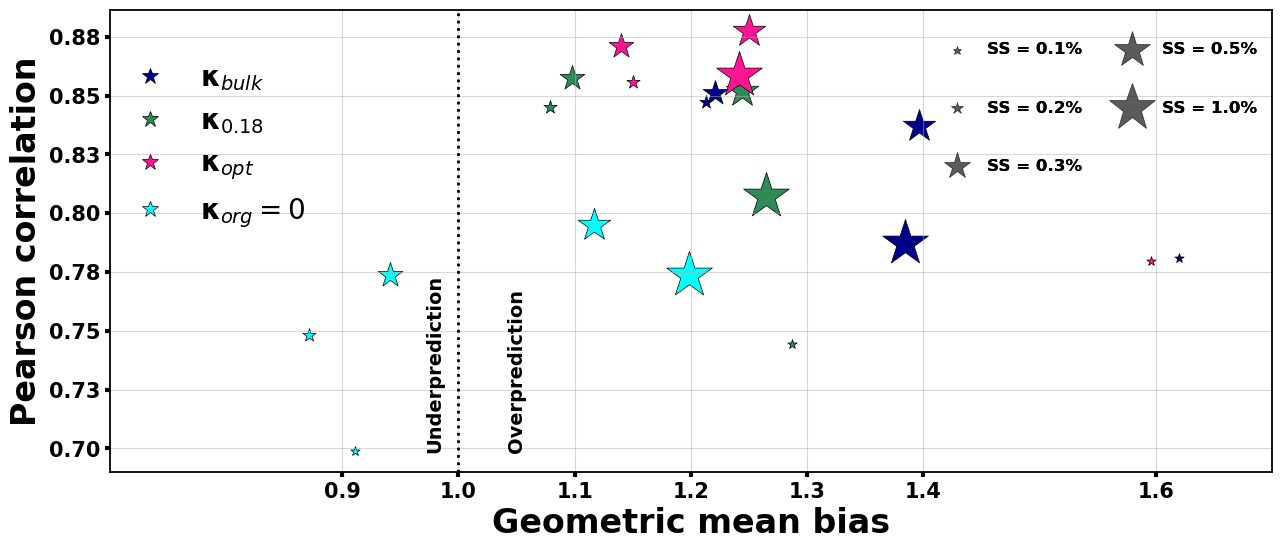

In [64]:
# Define supersaturation levels and their corresponding sizes
ss = [0.1, 0.2, 0.3, 0.5, 1.0]
ss_sizes = [50, 100, 150, 200, 300]  # Sizes for each SS level

# Define colors, markers, and labels
colors = ['darkblue', 'seagreen', 'deeppink', 'cyan']
#colors = ['darkblue', 'deeppink']
labels_method = [
    r'$\mathbf{\kappa}_{bulk}$', 
    r'$\mathbf{\kappa}_{0.18}$', 
    r'$\mathbf{\kappa}_{opt}$',
     r'$\mathbf{\kappa}_{org} = 0$'
]

# Calculate biases and correlations
bias_ACSM_BC = cal_bias(CCN_obs_harmonized, CCN_ACSM_harmonized_filt)
bias_sihto = cal_bias(CCN_obs_harmonized, CCN_sihto_harmonized_filt)
bias_opt = cal_bias(CCN_obs_harmonized, ccn_opt_harmonized_filt)
bias_no_org_kappa = cal_bias(CCN_obs_harmonized, CCN_org_zero_harmonized_filt)

corr_ACSM_BC = cal_corr(CCN_obs_harmonized, CCN_ACSM_harmonized_filt)
corr_sihto = cal_corr(CCN_obs_harmonized, CCN_sihto_harmonized_filt)
corr_opt = cal_corr(CCN_obs_harmonized, ccn_opt_harmonized_filt)
corr_no_org_kappa = cal_corr(CCN_obs_harmonized, CCN_org_zero_harmonized_filt)

biases = [bias_ACSM_BC, bias_sihto, bias_opt, bias_no_org_kappa]
corrs = [corr_ACSM_BC, corr_sihto, corr_opt, corr_no_org_kappa]

# Print the Bias (in %) and correlation values
methods = ['Bulk composition', 'Sihto', 'Optimized', 'kappa_org = 0']
for i in range(len(biases)):
    for j in range(len(ss)):
        bias_percent = (biases[i][j])  # Convert bias to percentage
        print(f"Bias ({methods[i]} - SS {ss[j]}%) = {bias_percent:.2f}% (Correlation = {corrs[i][j]:.3f})")


# Create the plot
fig, axs = plt.subplots(1, 1, figsize=(15, 6))
fig.set_facecolor('white')
ss_sizes = [50, 100, 350, 600, 1200]  # Sizes corresponding to each SS level
# Plot data
for i in range(len(biases)):
    for j in range(len(ss)):
        axs.scatter(biases[i][j], corrs[i][j], 
                    s=ss_sizes[j],  # Size based on SS level
                    marker='*',  # Use stars for all points
                    color=colors[i], 
                    edgecolors='black', 
                    linewidths=0.5, 
                    label=labels_method[i] if j == 0 else "")

# Limit y-axis tick labels to two decimal places
axs.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
axs.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

# Customize the plot
axs.set_ylabel('Pearson correlation', fontsize=24, fontname='sans-serif', fontweight='bold')
axs.set_xlabel('Geometric mean bias', fontname='sans-serif', fontsize=24, fontweight='bold')

axs.set_xticks([0.9,1.0,1.1, 1.2, 1.3, 1.4, 1.6, 1.8])
axs.set_xlim([0.7, 1.7])
axs.grid(which='both', alpha =0.5)
axs.axvline(x=1, linestyle=':', linewidth=2, color='k')



# Adjust the appearance

axs.spines['top'].set_linewidth(1.3)
axs.spines['bottom'].set_linewidth(1.3)
axs.spines['left'].set_linewidth(1.3)
axs.spines['right'].set_linewidth(1.3)
axs.spines['top'].set_color('k')
axs.spines['bottom'].set_color('k')
axs.spines['left'].set_color('k')
axs.spines['right'].set_color('k')

axs.tick_params(axis='both', labelsize=15, width=3)
for tick in axs.get_xticklabels() + axs.get_yticklabels():
    tick.set_fontname('sans-serif')
    tick.set_fontweight('bold')


# Legend for methods
legend_elements = [Line2D([0], [0], color=color, marker='*', linestyle='None', markersize=12, markeredgecolor='black', markeredgewidth=0.5, label=label) for color, label in zip(colors, labels_method)]
legend = axs.legend(handles=legend_elements, loc=(0.001, 0.5), ncol =1, frameon=False, prop={'family': 'sans-serif', 'weight': 'bold', 'size': 20})

# Adjust sizes for SS legend to match scatter plot
ss_legend_elements = []
size_marker = [50/8, 100/11, 350/18, 600/22, 850/24]
for size_marker, ss in zip(size_marker, ss_levels):
    # Add a marker and a line below it
    marker = Line2D([0], [0], color='black', linestyle='None', label=f'\nSS = {ss}%\n', marker='*', markersize=size_marker, markeredgewidth=0.5, alpha = 0.4)
    ss_legend_elements.append(marker)

# Creating a dummy legend for SS levels to simulate lines below markers
ss_legend = axs.legend(handles=ss_legend_elements, loc='upper right', frameon = False, ncol = 2, prop={'family': 'sans-serif', 'weight': 'bold', 'size': 12})

# Add the legends to the plot
axs.add_artist(legend)
axs.add_artist(ss_legend)

# Set font weight for ticks
for tick in axs.get_xticklabels() + axs.get_yticklabels():
    tick.set_fontweight('bold')
    tick.set_fontname('sans-serif')

# Add text annotations
axs.text(0.98, 0.7, 'Underprediction', fontsize=14, fontname='sans-serif', fontweight='bold', color='k', ha='center', rotation=90)
axs.text(1.05, 0.7, 'Overprediction', fontsize=14, fontname='sans-serif', fontweight='bold', color='k', ha='center', rotation=90)
plt.savefig('figures/paper_figures/Bias_non_hygroscopic_organics.png.png', dpi = 500)
plt.show()

<span style="color:darkblue; font-size:18px;font-weight:bold;"><i> plot observed mass fractions </i></span>  

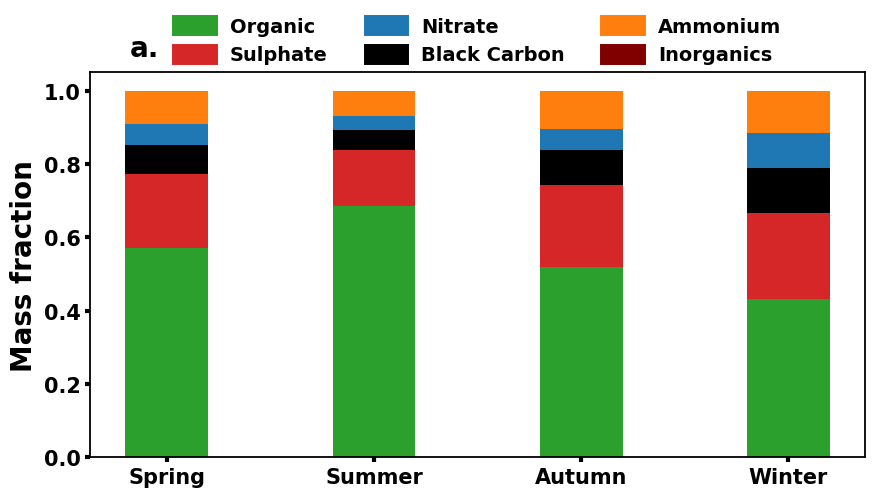

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

df_comp_orig_har = pd.read_csv('../../../../../../../Observation/Refine_Raw_observation/refined_raw_data/ACSM_eBC.csv')
df_comp_orig_har['datetime'] = pd.to_datetime(df_comp_orig_har['datetime'])
df_comp_orig_har.set_index('datetime', inplace = True)

# Define seasons
spring_months = [3, 4, 5]
summer_months = [6, 7, 8]
autumn_months = [9, 10, 11]
winter_months = [12, 1, 2]

# Group data by seasons
ACSM_seasonal_mean = pd.DataFrame()

total_mass_concentration = df_comp_orig_har.sum(axis=1)
# Calculate the mass fraction for each species by dividing by the total mass concentration
df_comp_orig_har_frac = df_comp_orig_har.div(total_mass_concentration, axis=0)

ACSM_seasonal_mean['Spring'] = df_comp_orig_har_frac[df_comp_orig_har_frac.index.month.isin(spring_months)].mean()
ACSM_seasonal_mean['Summer'] = df_comp_orig_har_frac[df_comp_orig_har_frac.index.month.isin(summer_months)].mean()
ACSM_seasonal_mean['Autumn'] = df_comp_orig_har_frac[df_comp_orig_har_frac.index.month.isin(autumn_months)].mean()
ACSM_seasonal_mean['Winter'] = df_comp_orig_har_frac[df_comp_orig_har_frac.index.month.isin(winter_months)].mean()

# Plot stacked histogram
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
width = 0.40

fig, ax = plt.subplots(figsize = (10, 5))

# Add subplot label (a., b., c., d.)
subplot_labels = ['a.']  # Labels for subplots
ax.text(0.07, 1.1, subplot_labels[0], transform=ax.transAxes, fontsize=20, 
            fontweight='bold', fontname='sans-serif', va='top', ha='center')

for i, season in enumerate(seasons):
    ax.bar(i - width / 2, ACSM_seasonal_mean.loc['Org', season], width, color = 'tab:green')
    
    ax.bar(i - width / 2, ACSM_seasonal_mean.loc['SO4', season], width, 
           bottom = ACSM_seasonal_mean.loc['Org', season], color = 'tab:red')
    
    ax.bar(i - width / 2, ACSM_seasonal_mean.loc['eBC880', season], width, 
           bottom= ACSM_seasonal_mean.loc['Org', season] + 
           ACSM_seasonal_mean.loc['SO4', season], color = 'k')
    
    ax.bar(i - width / 2, ACSM_seasonal_mean.loc['NO3', season], width, 
           bottom = ACSM_seasonal_mean.loc['Org', season] + 
           ACSM_seasonal_mean.loc['SO4', season] + ACSM_seasonal_mean.loc['eBC880', season], color = 'tab:blue')
    
    ax.bar(i - width / 2, ACSM_seasonal_mean.loc['NH4', season], width, 
           bottom = ACSM_seasonal_mean.loc['Org', season] + ACSM_seasonal_mean.loc['SO4', season] 
           + ACSM_seasonal_mean.loc['NO3', season]
           + ACSM_seasonal_mean.loc['eBC880', season], color = 'tab:orange')

#ax.set_xlabel('Season', font = 'serif', fontweight='bold',  fontsize=18)
ax.set_ylabel('Mass fraction', fontname = 'sans-serif', fontsize=20, fontweight='bold')
#.set_title('Seasonal Mean Mass Fractions of ACSM and Accumulation Modes')
ax.set_xticks(np.arange(len(seasons)) - width / 2)
#ax.set_xticks(np.arange(len(seasons)))
ax.set_xticklabels(seasons)

for tick in ax.get_xticklabels():
    tick.set_fontname("sans-serif")

for tick in ax.get_yticklabels():
    tick.set_fontname("sans-serif")

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.3)
    ax.spines[axis].set_color('k')

ax.tick_params(axis='both', labelsize=15, width=3)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

# Add custom legend patches ### change te fint type
patch1 = mpatches.Patch(color ='tab:green', label='Organic',linewidth = 5, edgecolor='black')
patch2 = mpatches.Patch(color ='tab:red', label='Sulphate',linewidth = 5, edgecolor='black')
patch3 = mpatches.Patch(color ='tab:blue', label='Nitrate',linewidth = 5, edgecolor='black')
patch4 = mpatches.Patch(color ='k', label='Black Carbon',linewidth = 5, edgecolor='black')
patch5 = mpatches.Patch(color ='tab:orange', label = 'Ammonium',linewidth = 5, edgecolor='black')
patch6 = mpatches.Patch(color ='maroon', label='Inorganics',linewidth = 5, edgecolor='black')

plt.legend(handles = [patch1, patch2, patch3, patch4, patch5, patch6], ncol = 3, loc = (0.1, 1), frameon = False, 
           prop = {'family': 'sans-serif', 'weight': 'bold', 'size':14})
plt.savefig('figures/paper_figures/Observed_coposition.png', dpi = 500)
plt.show()

In [ ]:
<span style="color:darkblue; font-size:18px;font-weight:bold;"><i> mean mass fractions of chemical species in Aitken and accumulation mode </i></span>  

Relative Enrichment of Sulfate in Accumulation Mode (%):
Spring     81.507490
Summer     51.688155
Autumn    106.316408
Winter    156.037292
dtype: float64


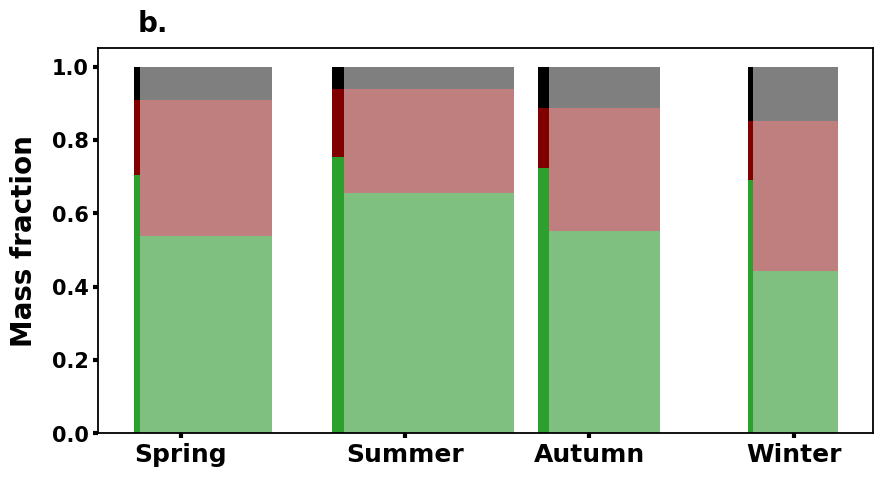

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# df_aitken and df_accumulation are DataFrames for Aitken and accumulation modes respectively

df_results_opt = pd.read_csv('result_nedler_mead_org0p12.csv')
df_results_opt['datetime'] = pd.to_datetime(df_results_opt['datetime'])
df_results_opt.set_index('datetime', inplace =  True)

df_aitken = df_results_opt[['f_org1',	'f_AS1',	'f_BC1', 	'mass_aitken']]
df_accumulation = df_results_opt[['f_org2',	'f_AS2',	'f_BC2', 	'mass_accumulation']]

# Define seasons
spring_months = [3, 4, 5]
summer_months = [6, 7, 8]
autumn_months = [9, 10, 11]
winter_months = [12, 1, 2]

# Group data by seasons
aitken_seasonal_mean = pd.DataFrame()
accumulation_seasonal_mean = pd.DataFrame()

aitken_seasonal_mass = pd.DataFrame()
accumulation_seasonal_mass = pd.DataFrame()

aitken_seasonal_mean['Spring'] = df_aitken[df_aitken.index.month.isin(spring_months)].mean()
aitken_seasonal_mean['Summer'] = df_aitken[df_aitken.index.month.isin(summer_months)].mean()
aitken_seasonal_mean['Autumn'] = df_aitken[df_aitken.index.month.isin(autumn_months)].mean()
aitken_seasonal_mean['Winter'] = df_aitken[df_aitken.index.month.isin(winter_months)].mean()

accumulation_seasonal_mean['Spring'] = df_accumulation[df_accumulation.index.month.isin(spring_months)].mean()
accumulation_seasonal_mean['Summer'] = df_accumulation[df_accumulation.index.month.isin(summer_months)].mean()
accumulation_seasonal_mean['Autumn'] = df_accumulation[df_accumulation.index.month.isin(autumn_months)].mean()
accumulation_seasonal_mean['Winter'] = df_accumulation[df_accumulation.index.month.isin(winter_months)].mean()

aitken_seasonal_mass['Spring'] = df_aitken[df_aitken.index.month.isin(spring_months)].median()
aitken_seasonal_mass['Summer'] = df_aitken[df_aitken.index.month.isin(summer_months)].median()
aitken_seasonal_mass['Autumn'] = df_aitken[df_aitken.index.month.isin(autumn_months)].median()
aitken_seasonal_mass['Winter'] = df_aitken[df_aitken.index.month.isin(winter_months)].median()

accumulation_seasonal_mass['Spring'] = df_accumulation[df_accumulation.index.month.isin(spring_months)].median()
accumulation_seasonal_mass['Summer'] = df_accumulation[df_accumulation.index.month.isin(summer_months)].median()
accumulation_seasonal_mass['Autumn'] = df_accumulation[df_accumulation.index.month.isin(autumn_months)].median()
accumulation_seasonal_mass['Winter'] = df_accumulation[df_accumulation.index.month.isin(winter_months)].median()

# Calculate relative enrichment of sulfate in accumulation mode
relative_enrichment_sulfate = (accumulation_seasonal_mean.loc['f_AS2'] - aitken_seasonal_mean.loc['f_AS1']) / aitken_seasonal_mean.loc['f_AS1'] * 100

# Print the results
print("Relative Enrichment of Sulfate in Accumulation Mode (%):")
print(relative_enrichment_sulfate)

# Plot stacked histogram
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
width = 0.35

fig, ax = plt.subplots(figsize = (10, 5))
# Add subplot label (a., b., c., d.)
subplot_labels = ['b.']  # Labels for subplots
ax.text(0.07, 1.1, subplot_labels[0], transform=ax.transAxes, fontsize=20, 
            fontweight='bold', fontname='sans-serif', va='top', ha='center')

for i, season in enumerate(seasons):
    ait_width = aitken_seasonal_mass.loc[aitken_seasonal_mass.index[3], season]*0.3
    ax.bar(i - ait_width / 2, aitken_seasonal_mean.loc['f_org1', season], ait_width, color='tab:green')
    ax.bar(i - ait_width / 2, aitken_seasonal_mean.loc['f_AS1', season], ait_width, bottom=aitken_seasonal_mean.loc['f_org1', season], color='maroon')
    ax.bar(i - ait_width / 2, aitken_seasonal_mean.loc['f_BC1', season], ait_width, 
           bottom=aitken_seasonal_mean.loc['f_org1', season] + aitken_seasonal_mean.loc['f_AS1', season], color='k')
    
    acc_width = accumulation_seasonal_mass.loc[accumulation_seasonal_mass.index[3], season]*0.3
    ax.bar(i + acc_width / 2, accumulation_seasonal_mean.loc['f_org2', season], acc_width, color='green', alpha=0.5)
    ax.bar(i + acc_width / 2, accumulation_seasonal_mean.loc['f_AS2', season], acc_width, bottom=accumulation_seasonal_mean.loc['f_org2', season], color='maroon', alpha=0.5)
    ax.bar(i + acc_width / 2, accumulation_seasonal_mean.loc['f_BC2', season], acc_width, 
           bottom=accumulation_seasonal_mean.loc['f_org2', season] + accumulation_seasonal_mean.loc['f_AS2', season], color='k', alpha=0.5)

#ax.set_xlabel('Season', font = 'serif', fontweight='bold',  fontsize=18)
ax.set_ylabel('Mass fraction', fontname='sans-serif', fontsize=20, fontweight='bold', labelpad=10)
#.set_title('Seasonal Mean Mass Fractions of Aitken and Accumulation Modes')
#ax.set_xticks(np.arange(len(seasons)) - width / 2)
ax.set_xticks([0.2, 1.3, 2.2, 3.2])
ax.set_xticklabels(seasons, fontsize = 25)

for tick in ax.get_xticklabels():
    tick.set_fontname("sans-serif")

for tick in ax.get_yticklabels():
    tick.set_fontname("sans-serif")

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.3)
    ax.spines[axis].set_color('k')

ax.tick_params(axis='y', labelsize = 15, width=3)
ax.tick_params(axis='x', labelsize = 18, width=3)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

# Add custom legend patches
#patch1 = mpatches.Patch(color='g', label='Organic')
#patch2 = mpatches.Patch(color='r', label='Ammonium Sulphate')
#patch3 = mpatches.Patch(color='k', label='Black Carbon')
patch1 = mpatches.Patch(color = 'tab:green', label = 'Aitken', linewidth = 4)

#width = 5
#height = 1  # You can adjust height as needed
# Add custom legend patches ### change te fint type
patch1 = mpatches.Patch(color ='tab:green', label = 'Organic',linewidth = 5, edgecolor='black')
patch2 = mpatches.Patch(color ='maroon', label = 'Inorganics',linewidth = 5, edgecolor='black')
patch3 = mpatches.Patch(color ='k', label = 'Black Carbon',linewidth = 5, edgecolor='black')
#patch5 = mpatches.Rectangle((0, 0), width = 5, height=4, color='g', alpha=0.4, label = 'Accumulation')
#patch4 = mpatches.Rectangle((0, 0), width = 5, height=4, color='g', alpha=0.4, label = 'Aitken')

#plt.legend(handles = [patch1, patch2, patch3], ncol = 5, loc = (0.15, 1.00), frameon = False, 
#           prop = {'family': 'serif', 'weight': 'bold', 'size': 12})
#plt.savefig('figures/paper_figures/optimized_mass_fraction.png', dpi = 500)
plt.show()


In [95]:
aitken_seasonal_mean

Spring    Summer    Autumn    Winter
f_org1       0.705404  0.752399  0.724301  0.691771
f_AS1        0.204490  0.186756  0.161578  0.160131
f_BC1        0.090107  0.060845  0.114121  0.148098
mass_aitken  0.334060  0.485252  0.342935  0.208769

In [ ]:
<span style="color:darkblue; font-size:18px;font-weight:bold;"><i> seasonal median mass fraction </i></span>  

In [96]:
import pandas as pd

# Calculate seasonal medians
aitken_seasonal_median = pd.DataFrame()
accumulation_seasonal_median = pd.DataFrame()

aitken_seasonal_median['Spring'] = df_aitken[df_aitken.index.month.isin(spring_months)].median()
aitken_seasonal_median['Summer'] = df_aitken[df_aitken.index.month.isin(summer_months)].median()
aitken_seasonal_median['Autumn'] = df_aitken[df_aitken.index.month.isin(autumn_months)].median()
aitken_seasonal_median['Winter'] = df_aitken[df_aitken.index.month.isin(winter_months)].median()

accumulation_seasonal_median['Spring'] = df_accumulation[df_accumulation.index.month.isin(spring_months)].median()
accumulation_seasonal_median['Summer'] = df_accumulation[df_accumulation.index.month.isin(summer_months)].median()
accumulation_seasonal_median['Autumn'] = df_accumulation[df_accumulation.index.month.isin(autumn_months)].median()
accumulation_seasonal_median['Winter'] = df_accumulation[df_accumulation.index.month.isin(winter_months)].median()

# Print the results
print("Aitken Seasonal Median:")
print(aitken_seasonal_median)

print("\nAccumulation Seasonal Median:")
print(accumulation_seasonal_median)

# Calculate relative enrichment of sulfate in accumulation mode
relative_enrichment_sulfate = (accumulation_seasonal_median.loc['f_AS2'] - aitken_seasonal_median.loc['f_AS1']) / aitken_seasonal_median.loc['f_AS1'] * 100

# Print the results
print("Relative Enrichment of Sulfate in Accumulation Mode (%):")
print(relative_enrichment_sulfate)

Aitken Seasonal Median:
               Spring    Summer    Autumn    Winter
f_org1       0.869693  0.914257  0.859152  0.823183
f_AS1        0.001421  0.000812  0.000323  0.000148
f_BC1        0.082921  0.056218  0.102806  0.136128
mass_aitken  0.097717  0.197619  0.167267  0.083327

Accumulation Seasonal Median:
                     Spring    Summer    Autumn    Winter
f_org2             0.549095  0.702619  0.571635  0.450507
f_AS2              0.349325  0.231176  0.304107  0.393187
f_BC2              0.082921  0.056218  0.102806  0.136128
mass_accumulation  2.156480  2.771375  1.809653  1.390897
Relative Enrichment of Sulfate in Accumulation Mode (%):
Spring     24488.518211
Summer     28385.760357
Autumn     94035.546834
Winter    266298.353859
dtype: float64


In [110]:
import pandas as pd

# Step 1: Calculate mass concentrations by multiplying fractions with total mass
df_aitken_mass = df_aitken.copy()
df_accumulation_mass = df_accumulation.copy()

df_aitken_mass['mass_org1'] = df_aitken_mass['f_org1'] * df_aitken_mass['mass_aitken']
df_aitken_mass['mass_AS1']  = df_aitken_mass['f_AS1']  * df_aitken_mass['mass_aitken']
df_aitken_mass['mass_BC1']  = df_aitken_mass['f_BC1']  * df_aitken_mass['mass_aitken']

df_accumulation_mass['mass_org2'] = df_accumulation_mass['f_org2'] * df_accumulation_mass['mass_accumulation']
df_accumulation_mass['mass_AS2']  = df_accumulation_mass['f_AS2']  * df_accumulation_mass['mass_accumulation']
df_accumulation_mass['mass_BC2']  = df_accumulation_mass['f_BC2']  * df_accumulation_mass['mass_accumulation']

# Step 2: Calculate seasonal medians of the mass concentrations
aitken_seasonal_median = pd.DataFrame()
accumulation_seasonal_median = pd.DataFrame()

aitken_seasonal_median['Spring'] = df_aitken_mass[df_aitken_mass.index.month.isin(spring_months)][['mass_org1', 'mass_AS1', 'mass_BC1']].median()
aitken_seasonal_median['Summer'] = df_aitken_mass[df_aitken_mass.index.month.isin(summer_months)][['mass_org1', 'mass_AS1', 'mass_BC1']].median()
aitken_seasonal_median['Autumn'] = df_aitken_mass[df_aitken_mass.index.month.isin(autumn_months)][['mass_org1', 'mass_AS1', 'mass_BC1']].median()
aitken_seasonal_median['Winter'] = df_aitken_mass[df_aitken_mass.index.month.isin(winter_months)][['mass_org1', 'mass_AS1', 'mass_BC1']].median()

accumulation_seasonal_median['Spring'] = df_accumulation_mass[df_accumulation_mass.index.month.isin(spring_months)][['mass_org2', 'mass_AS2', 'mass_BC2']].median()
accumulation_seasonal_median['Summer'] = df_accumulation_mass[df_accumulation_mass.index.month.isin(summer_months)][['mass_org2', 'mass_AS2', 'mass_BC2']].median()
accumulation_seasonal_median['Autumn'] = df_accumulation_mass[df_accumulation_mass.index.month.isin(autumn_months)][['mass_org2', 'mass_AS2', 'mass_BC2']].median()
accumulation_seasonal_median['Winter'] = df_accumulation_mass[df_accumulation_mass.index.month.isin(winter_months)][['mass_org2', 'mass_AS2', 'mass_BC2']].median()

# Step 3: Print seasonal medians
print("Aitken Seasonal Median (mass concentrations):")
print(aitken_seasonal_median)

print("\nAccumulation Seasonal Median (mass concentrations):")
print(accumulation_seasonal_median)

# Step 6: Calculate seasonal mass fractions from seasonal median mass concentrations
aitken_mass_fraction_from_medians = aitken_seasonal_median.div(aitken_seasonal_median.sum(axis=0))
accumulation_mass_fraction_from_medians = accumulation_seasonal_median.div(accumulation_seasonal_median.sum(axis=0))

# Step 7: Print mass fractions from seasonal medians
print("\nAitken Seasonal Mass Fractions (from median mass concentrations):")
print(aitken_mass_fraction_from_medians)

print("\nAccumulation Seasonal Mass Fractions (from median mass concentrations):")
print(accumulation_mass_fraction_from_medians)


Aitken Seasonal Median (mass concentrations):
             Spring    Summer    Autumn    Winter
mass_org1  0.067255  0.127939  0.111456  0.055237
mass_AS1   0.000013  0.000012  0.000011  0.000009
mass_BC1   0.007874  0.010343  0.016879  0.011375

Accumulation Seasonal Median (mass concentrations):
             Spring    Summer    Autumn    Winter
mass_org2  1.100099  1.864494  0.998151  0.659085
mass_AS2   0.745009  0.612057  0.560570  0.563471
mass_BC2   0.184269  0.158741  0.179633  0.198900

Aitken Seasonal Mass Fractions (from median mass concentrations):
             Spring    Summer    Autumn    Winter
mass_org1  0.895040  0.925122  0.868405  0.829117
mass_AS1   0.000172  0.000087  0.000087  0.000133
mass_BC1   0.104788  0.074790  0.131508  0.170749

Accumulation Seasonal Mass Fractions (from median mass concentrations):
             Spring    Summer    Autumn    Winter
mass_org2  0.542087  0.707510  0.574193  0.463669
mass_AS2   0.367112  0.232254  0.322472  0.396404
mass_BC2   

In [ ]:
<span style="color:darkblue; font-size:18px;font-weight:bold;"><i>  median kappa in seasons </i></span> 

In [69]:
df_kappa_opt = df_results_opt[['k1', 'k2']]

# Extract seasons from the datetime index
seasons = df_kappa_opt.index.month.map({
    3: 'Spring', 4: 'Spring', 5: 'Spring', 
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn',
    1: 'Winter', 2: 'Winter', 12: 'Winter', 
})

# Add a new column 'Season' to the DataFrame
df_kappa_opt['Season'] = seasons

# Define the seasons
season_names = ['Winter', 'Spring', 'Summer', 'Autumn']

# Calculate and print the median values for each season and column
for season in season_names:
    median_kappa_mode1 = df_kappa_opt[df_kappa_opt['Season'] == season]['k1'].median()
    median_kappa_mode2 = df_kappa_opt[df_kappa_opt['Season'] == season]['k2'].median()
    
    # Calculate percentage difference
    percentage_diff = ((median_kappa_mode2 - median_kappa_mode1) / median_kappa_mode1) * 100
    
    # Print results
    print(f"Season: {season}")
    print(f"Median Kappa_mode 1 (Aitken): {median_kappa_mode1:.2f}")
    print(f"Median Kappa_mode 2 (Accumulation): {median_kappa_mode2:.2f}")
    print(f"Percentage Difference: {percentage_diff:.2f}%")
    print("-" * 40)  # Separator for clarity
    print("\n")


Season: Winter
Median Kappa_mode 1 (Aitken): 0.11
Median Kappa_mode 2 (Accumulation): 0.29
Percentage Difference: 162.50%
----------------------------------------


Season: Spring
Median Kappa_mode 1 (Aitken): 0.12
Median Kappa_mode 2 (Accumulation): 0.27
Percentage Difference: 133.70%
----------------------------------------


Season: Summer
Median Kappa_mode 1 (Aitken): 0.12
Median Kappa_mode 2 (Accumulation): 0.22
Percentage Difference: 84.80%
----------------------------------------


Season: Autumn
Median Kappa_mode 1 (Aitken): 0.11
Median Kappa_mode 2 (Accumulation): 0.25
Percentage Difference: 116.59%
----------------------------------------




<span style="color:darkblue; font-size:18px;font-weight:bold;"><i> Distribution of kappa </i></span>  

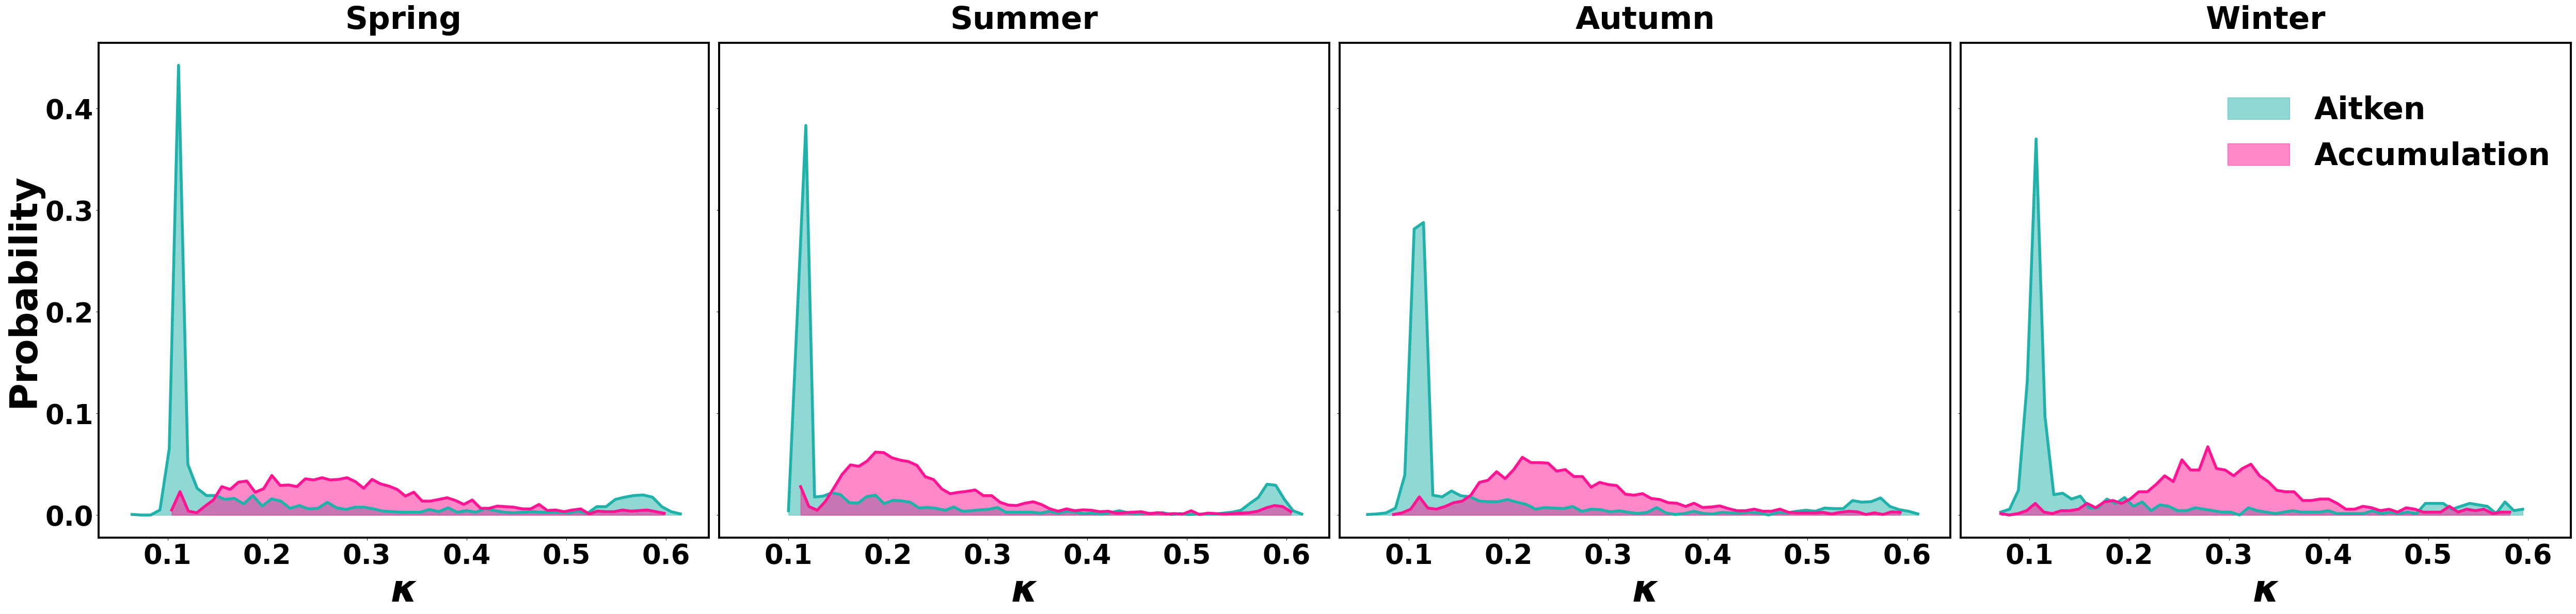

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Define color palette
colors = {"Aitken": "lightseagreen", "Accumulation": "deeppink"}

# Reshape the data
plot_data = df_kappa_opt.melt(id_vars=["Season"], value_vars=["k1", "k2"], 
                              var_name="Type", value_name="Kappa")
plot_data["Type"] = plot_data["Type"].map({"k1": "Aitken", "k2": "Accumulation"})

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(50, 12), sharex=True, sharey=True)

# Iterate over seasons
for ax, season in zip(axes, ["Spring", "Summer", "Autumn", "Winter"]):
    
    for typ, color in colors.items():
        # Select data
        data = plot_data[(plot_data["Season"] == season) & (plot_data["Type"] == typ)]["Kappa"].dropna()
        
        if len(data) > 1:  # Ensure enough data points
            # Compute histogram-based probability
            counts, bins = np.histogram(data, bins  =60, density=False)  # Count occurrences
            probabilities = counts / np.sum(counts)  # Normalize to sum to 1
            bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute bin centers
            
            # Plot probability distribution
            ax.plot(bin_centers, probabilities, color=color, lw=4)
            ax.fill_between(bin_centers, probabilities, color=color, alpha=0.5)
    
    # Format plot
    ax.set_title(season, fontsize=44, fontweight="bold", fontname="sans-serif", y = 1.02)
    ax.set_xlabel(r'$\boldsymbol{\kappa}$', fontsize=53, fontweight='bold', fontname='sans-serif')
    
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2.8)
        ax.spines[axis].set_color('k')
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname("sans-serif")
        label.set_fontweight("bold")

    ax.tick_params(axis='both', labelsize=38)
    
axes.flat[0].set_ylabel("Probability", fontsize=53, fontweight="bold", fontname="sans-serif")
# Legend
handles = [mpatches.Patch(color=color, alpha=0.5, label=label) for label, color in colors.items()]
fig.legend(handles, colors.keys(), loc=(0.86, 0.7), frameon=False, 
           prop={'family': 'sans-serif', 'weight': 'bold', 'size': 43}) 

plt.tight_layout()
plt.savefig('figures/paper_figures/kappa_probability_seasonal.png', dpi=500)
plt.show()
